<b><font size="6">Newlan: Project Machine Learning </font><a class="anchor"><a id='toc'></a></b><br>

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, LogisticRegression, PassiveAggressiveClassifier
from sklearn.feature_selection import RFE, chi2, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, RepeatedKFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestCentroid, NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from factor_analyzer import FactorAnalyzer
from matplotlib.legend_handler import HandlerLine2D
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier,GradientBoostingClassifier, VotingClassifier, StackingClassifier, RandomForestClassifier

## 2. Import Dataset

In [2]:
data = pd.read_excel('Train.xlsx')

In [3]:
test = pd.read_excel('Test.xlsx')

## 3. Explore Dataset

In [4]:
data.shape

(22400, 15)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22400 entries, 0 to 22399
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CITIZEN_ID              22400 non-null  int64 
 1   Name                    22400 non-null  object
 2   Birthday                22400 non-null  object
 3   Native Continent        22400 non-null  object
 4   Marital Status          22400 non-null  object
 5   Lives with              22400 non-null  object
 6   Base Area               22400 non-null  object
 7   Education Level         22400 non-null  object
 8   Years of Education      22400 non-null  int64 
 9   Employment Sector       22400 non-null  object
 10  Role                    22400 non-null  object
 11  Working Hours per week  22400 non-null  int64 
 12  Money Received          22400 non-null  int64 
 13  Ticket Price            22400 non-null  int64 
 14  Income                  22400 non-null  int64 
dtypes:

In [6]:
data.describe()

,CITIZEN_ID,Years of Education,Working Hours per week,Money Received,Ticket Price,Income
count,22400.000000,22400.000000,22400.000000,22400.000000,22400.000000,22400.000000
mean,23685.500000,13.173884,40.483795,1324.915357,109.145313,0.237098
std,6466.467351,2.512451,12.370921,9227.771813,500.208904,0.425313
min,12486.000000,2.000000,1.000000,0.000000,0.000000,0.000000
25%,18085.750000,12.000000,40.000000,0.000000,0.000000,0.000000
50%,23685.500000,13.000000,40.000000,0.000000,0.000000,0.000000
75%,29285.250000,15.000000,45.000000,0.000000,0.000000,0.000000
max,34885.000000,21.000000,99.000000,122999.000000,5358.000000,1.000000


In [7]:
data['Income'].value_counts(normalize=True) # Percentage dependent variable 

0    0.762902
1    0.237098
Name: Income, dtype: float64

## 4. Data Preprocessing

### 4.1. Transform and Creating Variables

In [8]:
# SET INDEX
data.set_index('CITIZEN_ID', inplace = True)


# Replace '?' with NaN in order to python identify them as missing values
data.replace('?', np.nan, inplace=True)
test.replace('?', np.nan, inplace=True)


# CREATE VARIABLES

# Age
data[['Birthday','Year of Birth']] = data["Birthday"].str.split(",", n = 1, expand = True)
data['Year of Birth'] = data['Year of Birth'].astype(int)
data['Age'] = 2048 - data['Year of Birth']

test[['Birthday','Year of Birth']] = test["Birthday"].str.split(",", n = 1, expand = True)
test['Year of Birth'] = test['Year of Birth'].astype(int)
test['Age'] = 2048 - test['Year of Birth']



# Group B
data['Group B'] = np.where(data['Money Received'] > 0, 1, 0)
test['Group B'] = np.where(test['Money Received'] > 0, 1, 0)

# Group A
data['Group A'] = np.where((data['Money Received'] == 0) & (data['Ticket Price'] == 0), 1, 0)
test['Group A'] = np.where((test['Money Received'] == 0) & (test['Ticket Price'] == 0), 1, 0)


# Male
data['Male'] = '0' 
data.loc[data['Name'].str.startswith("Mr."), "Male" ] = "1" 
data.loc[data['Name'].str.startswith("Mrs."), "Male" ] = "0" 
data.loc[data['Name'].str.startswith("Miss"), "Male" ] = "0"

test['Male'] = '0' 
test.loc[test['Name'].str.startswith("Mr."), "Male" ] = "1" 
test.loc[test['Name'].str.startswith("Mrs."), "Male" ] = "0" 
test.loc[test['Name'].str.startswith("Miss"), "Male" ] = "0"

# Higher Education
data['Higher Education'] = np.where(data['Years of Education']>13, 1, 0)
test['Higher Education'] = np.where(test['Years of Education']>13, 1, 0)


# DROP VARIABLES
data.drop(["Birthday", "Year of Birth","Name","Education Level"], axis=1, inplace = True)
test.drop(["Birthday", "Year of Birth","Name","Education Level"], axis=1, inplace = True)

### 4.2. Incoherences

In [9]:
incoherence_1 = data[((data['Employment Sector'] == 'Unemployed') | (data['Employment Sector'] == 'Never Worked')) & (data['Working Hours per week'] > 0)].index
data.drop(incoherence_1,inplace = True)

incoherence_2 = data[((data['Marital Status'] == 'Married - Spouse Missing') | (data['Marital Status'] == 'Married - Spouse in the Army') | (data['Marital Status'] == 'Single') | (data['Marital Status'] == 'Divorced') | (data['Marital Status'] == 'Separated') | (data['Marital Status'] == 'Widow')) & ((data['Lives with'] == 'Wife') | (data['Lives with'] == 'Husband'))].index
data.drop(incoherence_2,inplace = True)

incoherence_3 = data[(data['Role'] == 'Army') & (data['Employment Sector'] != 'Public Sector - Government')].index
data.drop(incoherence_3,inplace = True)

incoherence_4 = data[(data['Age'] < 17) | (data['Age'] > 120)].index
data.drop(incoherence_4,inplace = True)

incoherence_5 = data[(data['Age'] < data['Years of Education'])].index
data.drop(incoherence_5,inplace = True)

incoherence_6 = data[(data['Group B']==1) & (data['Group A']==1)].index
data.drop(incoherence_6, inplace= True)

### 4.3. Data Partition

In [10]:
target = data["Income"]
data = data.drop(columns=["Income"])

In [11]:
X_train, X_validation,y_train, y_validation = train_test_split(data,target,
                                                               train_size = 0.7, 
                                                               shuffle = True, 
                                                               stratify = target)

### 4.4. Outliers 

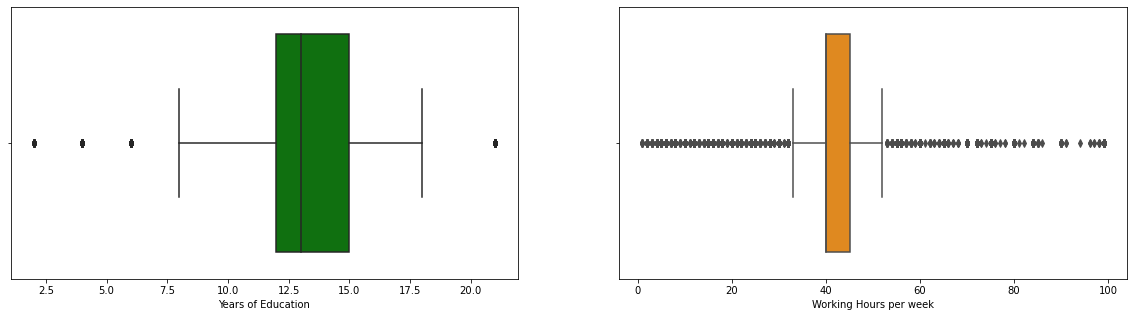

In [12]:
f, axes = plt.subplots(1,2, figsize=(20, 5), squeeze=False)    
sns.boxplot(X_train["Years of Education"], color="green", ax=axes[0, 0])
sns.boxplot(X_train["Working Hours per week"], color="darkorange", ax=axes[0, 1])

plt.show()

In [13]:
# Remove outliers in Years of Education with IQR
q25 = X_train["Years of Education"].quantile(.25)
q75 = X_train["Years of Education"].quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters = []

filters.append(X_train["Years of Education"].between(lower_lim, upper_lim, inclusive=True))

data_2 = X_train[np.all(filters, 0)]
print('Percentage of data kept after removing outliers:', np.round(data_2.shape[0] / X_train.shape[0], 4))

Percentage of data kept after removing outliers: 0.9701


In [14]:
# Remove outliers in Working Hours per week with IQR
q25 = X_train["Working Hours per week"].quantile(.25)
q75 = X_train["Working Hours per week"].quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters = []

filters.append(X_train["Working Hours per week"].between(lower_lim, upper_lim, inclusive=True))

data_2 = X_train[np.all(filters, 0)]
print('Percentage of data kept after removing outliers:', np.round(data_2.shape[0] / X_train.shape[0], 4))

Percentage of data kept after removing outliers: 0.7252


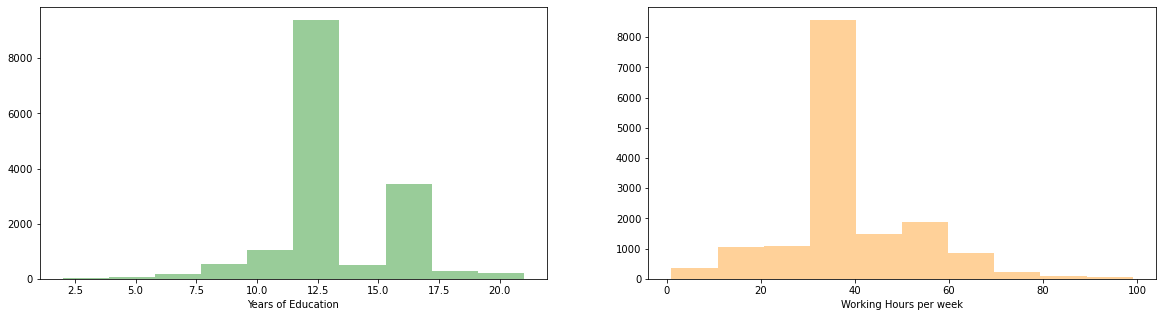

In [15]:
# histogram of Years of Education and Working Hours per week

f, axes = plt.subplots(1,2, figsize=(20, 5), squeeze=False)    
sns.distplot(X_train['Years of Education'], bins=10, color='green', kde=False, ax=axes[0,0])
sns.distplot(X_train['Working Hours per week'], bins=10, color='darkorange', kde=False, ax=axes[0,1])

plt.show()

In [16]:
#Remove outliers manually 

filters = []

filters.append(X_train["Years of Education"].between(5, 21, inclusive=True))
filters.append(X_train["Working Hours per week"].between(10, 80, inclusive=True))

data_2 = X_train[np.all(filters, 0)]
print('Percentage of data kept after removing outliers:', np.round(data_2.shape[0] / X_train.shape[0], 4))

X_train = data_2

y_train = y_train.get(y_train.index.isin(X_train.index))

Percentage of data kept after removing outliers: 0.9732


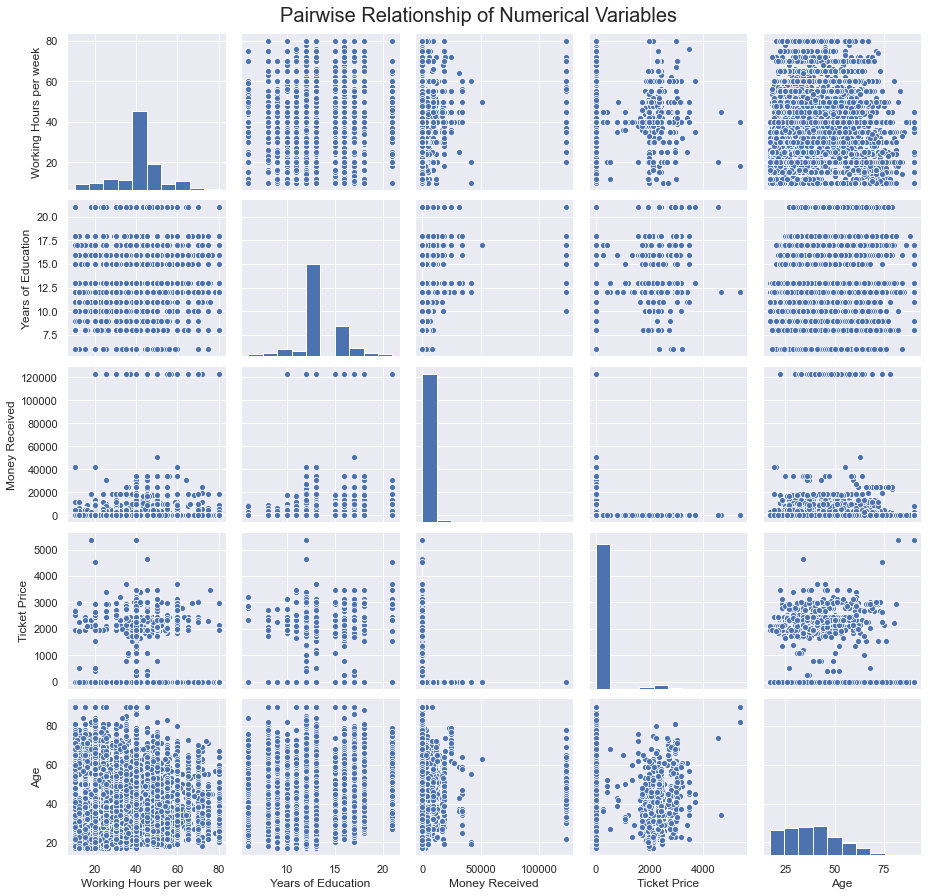

In [17]:
# Pairwise Relationship of Numerical Variables
sns.set()

# Setting pairplot
sns.pairplot(X_train[["Working Hours per week", "Years of Education", "Money Received", "Ticket Price", "Age"]], diag_kind="hist")

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

plt.show()

### 4.5. Missing Values 

#### 4.5.1. Missing Values - X Train

In [18]:
print("Number of missing values by variable:")
X_train.isnull().sum()

Number of missing values by variable:


Native Continent            0
Marital Status              0
Lives with                  0
Base Area                 268
Years of Education          0
Employment Sector         779
Role                      779
Working Hours per week      0
Money Received              0
Ticket Price                0
Age                         0
Group B                     0
Group A                     0
Male                        0
Higher Education            0
dtype: int64

##### Base Area

In [19]:
X_train['Base Area'].value_counts()

Northbury        13739
Fanfoss            260
Alverton            85
Butterpond          69
Watford             56
Laewaes             47
Auchenshuggle       47
Pran                47
Aroonshire          43
Sharnwick           42
Wigston             41
Fool's March        40
Eelry               40
Aerilon             35
Sharpton            34
Lanercost           33
Cherrytown          30
Knife's Edge        28
Kirkwall            27
King's Watch        26
Bellmoral           25
Laenteglos          20
Tranmere            19
Drumchapel          15
Aberuthven          14
Orilon              14
Kald                13
Lewes               11
Willesden           11
MillerVille          9
Carlisle             9
Middlesbrough        8
Conriston            8
Marnmouth            8
Woodpine             6
Redwick Bush         5
Bellenau             5
Mensfield            2
Name: Base Area, dtype: int64

In [20]:
X_train['Base Area'] = X_train['Base Area'].fillna(X_train['Base Area'].mode()[0])

##### Employment Sector

In [21]:
X_train['Employment Sector'].value_counts()

Private Sector - Services     10706
Self-Employed (Individual)     1181
Public Sector - Others          968
Private Sector - Others         602
Self-Employed (Company)         526
Public Sector - Government      477
Name: Employment Sector, dtype: int64

In [22]:
X_train['Employment Sector'] = X_train['Employment Sector'].fillna(X_train['Employment Sector'].mode()[0])

##### Role 

In [23]:
X_train['Role'].unique()

array(['Administratives', 'Repair & constructions', 'Sales', 'Management',
       'Professor', 'Agriculture and Fishing', 'Cleaners & Handlers',
       'Other services', 'Security', 'Transports',
       'Machine Operators & Inspectors', nan, 'IT', 'Household Services',
       'Army'], dtype=object)

In [24]:
X_train['Role'] = X_train['Role'].astype(str)

In [25]:
le = LabelEncoder()

X_train['Role'] = le.fit_transform(X_train['Role'])

In [26]:
X_train['Role'].unique()

array([ 0, 10, 11,  7,  9,  1,  3,  8, 12, 13,  6, 14,  5,  4,  2])

In [27]:
X_train['Role'].replace([14],np.nan,inplace=True)
X_train['Role'].unique()

array([ 0., 10., 11.,  7.,  9.,  1.,  3.,  8., 12., 13.,  6., nan,  5.,
        4.,  2.])

In [28]:
numeric_features = ['Years of Education','Role','Working Hours per week','Money Received','Ticket Price','Age']
df = X_train[numeric_features]

In [29]:
imputer = KNNImputer(n_neighbors=1).fit(df)

In [30]:
filled_data = imputer.transform(df)

In [31]:
df_2 = pd.DataFrame(filled_data, columns = df.columns)
df_2.head()

,Years of Education,Role,Working Hours per week,Money Received,Ticket Price,Age
0,12.0,0.0,40.0,0.0,0.0,20.0
1,13.0,10.0,45.0,0.0,0.0,32.0
2,13.0,0.0,40.0,0.0,0.0,36.0
3,16.0,11.0,40.0,0.0,0.0,28.0
4,16.0,7.0,28.0,18480.0,0.0,28.0


In [32]:
df_2['Role'] = df_2['Role'].astype(int)
df_2['Role'] = le.inverse_transform(df_2['Role'])
X_train.drop('Role',axis=1,inplace=True)

In [33]:
df_2.reset_index(drop=True, inplace=True)
X_train = pd.concat([X_train.reset_index(drop=True),df_2.Role],axis=1)
X_train.head()

,Native Continent,Marital Status,Lives with,Base Area,Years of Education,Employment Sector,Working Hours per week,Money Received,Ticket Price,Age,Group B,Group A,Male,Higher Education,Role
0,Europe,Single,Children,Northbury,12,Private Sector - Services,40,0,0,20,0,1,0,0,Administratives
1,Europe,Married,Wife,Northbury,13,Private Sector - Services,45,0,0,32,0,1,1,0,Repair & constructions
2,Europe,Married,Wife,Northbury,13,Private Sector - Services,40,0,0,36,0,1,1,0,Administratives
3,Europe,Married,Wife,Northbury,16,Private Sector - Services,40,0,0,28,0,1,1,1,Sales
4,Europe,Married,Husband,Northbury,16,Private Sector - Services,28,18480,0,28,1,0,0,1,Management


#### 4.5.2. Missing Values - X Validation

In [34]:
print("Number of missing values by variable:")
X_validation.isnull().sum()

Number of missing values by variable:


Native Continent            0
Marital Status              0
Lives with                  0
Base Area                 119
Years of Education          0
Employment Sector         394
Role                      394
Working Hours per week      0
Money Received              0
Ticket Price                0
Age                         0
Group B                     0
Group A                     0
Male                        0
Higher Education            0
dtype: int64

###### Base Area

In [35]:
X_validation['Base Area'].value_counts()

Northbury        5991
Fanfoss           138
Alverton           47
Sharnwick          28
Pran               27
Butterpond         26
Watford            26
Auchenshuggle      24
Lanercost          19
Aroonshire         17
Sharpton           17
Laewaes            16
Cherrytown         16
Fool's March       16
King's Watch       14
Eelry              14
Bellmoral          13
Wigston            13
Kirkwall           13
Laenteglos         11
Tranmere           10
Aerilon            10
Carlisle            9
Knife's Edge        8
Drumchapel          8
Aberuthven          8
MillerVille         8
Orilon              7
Mensfield           7
Willesden           5
Kald                5
Lewes               5
Conriston           4
Woodpine            3
Bellenau            3
Redwick Bush        2
Marnmouth           2
Ironforge           1
Middlesbrough       1
Name: Base Area, dtype: int64

In [36]:
X_validation['Base Area'] = X_validation['Base Area'].fillna(X_validation['Base Area'].mode()[0])

##### Employment Sector

In [37]:
X_validation['Employment Sector'].value_counts()

Private Sector - Services     4657
Self-Employed (Individual)     521
Public Sector - Others         439
Private Sector - Others        269
Self-Employed (Company)        223
Public Sector - Government     208
Name: Employment Sector, dtype: int64

In [38]:
X_validation['Employment Sector'] = X_validation['Employment Sector'].fillna(X_validation['Employment Sector'].mode()[0])

##### Role

In [39]:
X_validation['Role'].unique()

array(['Transports', 'Other services', 'Sales', 'Administratives',
       'Management', 'Repair & constructions', 'IT',
       'Cleaners & Handlers', 'Professor',
       'Machine Operators & Inspectors', nan, 'Agriculture and Fishing',
       'Security', 'Household Services', 'Army'], dtype=object)

In [40]:
X_validation['Role'] = X_validation['Role'].astype(str)

In [41]:
le = LabelEncoder()

X_validation['Role'] = le.fit_transform(X_validation['Role'])

In [42]:
X_validation['Role'].unique()

array([13,  8, 11,  0,  7, 10,  5,  3,  9,  6, 14,  1, 12,  4,  2])

In [43]:
X_validation['Role'].replace([14],np.nan,inplace=True)
X_validation['Role'].unique()

array([13.,  8., 11.,  0.,  7., 10.,  5.,  3.,  9.,  6., nan,  1., 12.,
        4.,  2.])

In [44]:
numeric_features = ['Years of Education','Role','Working Hours per week','Money Received','Ticket Price','Age']
dataframe = X_validation[numeric_features]

In [45]:
imputer = KNNImputer(n_neighbors=1).fit(dataframe)

In [46]:
filled_data = imputer.transform(dataframe)

In [47]:
df_2 = pd.DataFrame(filled_data, columns = dataframe.columns)

In [48]:
df_2['Role'] = df_2['Role'].astype(int)
df_2['Role'] = le.inverse_transform(df_2['Role'])
X_validation.drop('Role',axis=1,inplace=True)

In [49]:
df_2.reset_index(drop=True, inplace=True)
X_validation = pd.concat([X_validation.reset_index(drop=True),df_2.Role],axis=1)

#### 4.5.3. Missing Values - Test

In [50]:
print("Number of missing values by variable:")
test.isnull().sum()

Number of missing values by variable:


CITIZEN_ID                  0
Native Continent            0
Marital Status              0
Lives with                  0
Base Area                 187
Years of Education          0
Employment Sector         570
Role                      570
Working Hours per week      0
Money Received              0
Ticket Price                0
Age                         0
Group B                     0
Group A                     0
Male                        0
Higher Education            0
dtype: int64

###### Base Area

In [51]:
test['Base Area'].value_counts()

Northbury        9055
Fanfoss           200
Alverton           63
Butterpond         40
Watford            38
Pran               37
Laewaes            35
Fool's March       31
Aroonshire         31
Sharnwick          30
Lanercost          29
Auchenshuggle      26
Wigston            24
Kirkwall           22
Sharpton           21
King's Watch       20
Cherrytown         19
Bellmoral          19
Eelry              17
Aerilon            15
Tranmere           14
Knife's Edge       14
Willesden          12
Drumchapel         12
Aberuthven         11
Laenteglos         11
Kald               10
Middlesbrough       9
Lewes               8
Marnmouth           7
Orilon              7
Conriston           6
Redwick Bush        5
Mensfield           5
Bellenau            4
Woodpine            3
MillerVille         3
Name: Base Area, dtype: int64

In [52]:
test['Base Area'] = test['Base Area'].fillna(test['Base Area'].mode()[0])

##### Employment Sector

In [53]:
test['Employment Sector'].value_counts()

Private Sector - Services     7052
Self-Employed (Individual)     772
Public Sector - Others         672
Private Sector - Others        417
Self-Employed (Company)        349
Public Sector - Government     266
Unemployed                       2
Name: Employment Sector, dtype: int64

In [54]:
test['Employment Sector'] = test['Employment Sector'].fillna(test['Employment Sector'].mode()[0])

##### Role

In [55]:
test['Role'].unique()

array(['Sales', 'Professor', 'Management',
       'Machine Operators & Inspectors', 'Administratives',
       'Agriculture and Fishing', nan, 'Other services',
       'Repair & constructions', 'Transports', 'Cleaners & Handlers',
       'IT', 'Security', 'Household Services', 'Army'], dtype=object)

In [56]:
test['Role'] = test['Role'].astype(str)

In [57]:
le = LabelEncoder()

test['Role'] = le.fit_transform(test['Role'])

In [58]:
test['Role'].unique()

array([11,  9,  7,  6,  0,  1, 14,  8, 10, 13,  3,  5, 12,  4,  2])

In [59]:
test['Role'].replace([14],np.nan,inplace=True)
test['Role'].unique()

array([11.,  9.,  7.,  6.,  0.,  1., nan,  8., 10., 13.,  3.,  5., 12.,
        4.,  2.])

In [60]:
numeric_features = ['Years of Education','Role','Working Hours per week','Money Received','Ticket Price','Age']
dataframe = test[numeric_features]

In [61]:
imputer = KNNImputer(n_neighbors=1).fit(dataframe)

In [62]:
filled_data = imputer.transform(dataframe)

In [63]:
df_2 = pd.DataFrame(filled_data, columns = dataframe.columns)

In [64]:
df_2['Role'] = df_2['Role'].astype(int)
df_2['Role'] = le.inverse_transform(df_2['Role'])
test.drop('Role',axis=1,inplace=True)

In [65]:
df_2.reset_index(drop=True, inplace=True)
test = pd.concat([test.reset_index(drop=True),df_2.Role],axis=1)

### 4.6.One Hot Encoding

In [66]:
non_metric_features = ["Native Continent", "Marital Status", "Lives with",  "Base Area", "Employment Sector", "Role"]
metric_features = X_train.columns.drop(non_metric_features).to_list()

#### 4.6.1. Category Aggregation - X Train

##### Base Area

In [67]:
X_train['Base Area'].value_counts()

Northbury        14007
Fanfoss            260
Alverton            85
Butterpond          69
Watford             56
Laewaes             47
Auchenshuggle       47
Pran                47
Aroonshire          43
Sharnwick           42
Wigston             41
Fool's March        40
Eelry               40
Aerilon             35
Sharpton            34
Lanercost           33
Cherrytown          30
Knife's Edge        28
Kirkwall            27
King's Watch        26
Bellmoral           25
Laenteglos          20
Tranmere            19
Drumchapel          15
Aberuthven          14
Orilon              14
Kald                13
Lewes               11
Willesden           11
MillerVille          9
Carlisle             9
Middlesbrough        8
Conriston            8
Marnmouth            8
Woodpine             6
Redwick Bush         5
Bellenau             5
Mensfield            2
Name: Base Area, dtype: int64

In [68]:
for i in range (len(X_train)):
    if X_train['Base Area'][i] != 'Northbury':
        X_train['Base Area'][i] = 'Not Northbury'
    else:
        X_train['Base Area'][i] = 'Northbury'

##### Marital Status

In [69]:
X_train['Marital Status'].value_counts()

Married                     6983
Single                      5093
Divorced                    2068
Separated                    474
Widow                        440
Married - Spouse Missing     181
Name: Marital Status, dtype: int64

In [70]:
for i in range (len(X_train)):
    if (X_train["Marital Status"][i]=='Divorced') or (X_train["Marital Status"][i]=='Single') or (X_train["Marital Status"][i]=="Widow") or (X_train["Marital Status"][i]=="Separated"):
        X_train["Marital Status"][i]="Alone"
    else:
        X_train["Marital Status"][i]="Together"

##### Lives With

In [71]:
X_train['Lives with'].value_counts()

Wife               6145
Other Family       3920
Children           2370
Alone              1616
Husband             731
Other relatives     457
Name: Lives with, dtype: int64

In [72]:
for i in range (len(X_train)):
    if X_train["Lives with"][i]=='Alone':
        X_train["Lives with"][i]="Lives Alone"
    else:
        X_train["Lives with"][i]="Lives with someone"

##### Employment Sector

In [73]:
X_train['Employment Sector'].value_counts()

Private Sector - Services     11485
Self-Employed (Individual)     1181
Public Sector - Others          968
Private Sector - Others         602
Self-Employed (Company)         526
Public Sector - Government      477
Name: Employment Sector, dtype: int64

In [74]:
for i in range (len(X_train)):
    if (X_train['Employment Sector'][i]== 'Self-Employed (Company)') or (X_train['Employment Sector'][i]=='Self-Employed (Individual)') :
        X_train['Employment Sector'][i]="Self-Employed"
    elif (X_train['Employment Sector'][i]=='Public Sector - Others') or (X_train['Employment Sector'][i]== 'Public Sector - Government'):
        X_train['Employment Sector'][i]="Public Sector"
    else:
        X_train['Employment Sector'][i]="Private"

##### Role

In [75]:
for i in range (len(X_train)):
    if (X_train['Role'][i]== 'Agriculture and Fishing') or (X_train['Role'][i]=='Repair & constructions') or (X_train['Role'][i]=='Cleaners & Handlers') or (X_train['Role'][i]=='Household Services'):
        X_train['Role'][i]="Low qualification Jobs"
    elif (X_train['Role'][i]=='Security') or (X_train['Role'][i]== 'Machine Operators & Inspectors') or (X_train['Role'][i]== 'Sales') or (X_train['Role'][i]== 'Transports') or (X_train['Role'][i]== 'Army') :
        X_train['Role'][i]="Medium qualification Jobs"
    elif X_train['Role'][i]=='Other services':
        X_train['Role'][i]='Other services'
    elif (X_train['Role'][i]=='Administratives') or (X_train['Role'][i]== 'Professor') or (X_train['Role'][i]== 'IT') or (X_train['Role'][i]== 'Management'):
        X_train['Role'][i]="High qualification Jobs"

#### 4.6.2. One Hot Encoding - X Train

In [76]:
data_ohc=X_train.copy()

In [77]:
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(data_ohc[non_metric_features])
ohc_feat_names = ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=data_ohc.index, columns=ohc_feat_names) 

In [78]:
data_ohc = pd.concat([data_ohc.drop(columns=non_metric_features), ohc_df], axis=1)

In [79]:
X_train = data_ohc.copy()

#### 4.6.3. Category Aggregation - X Validation

##### Base Area

In [80]:
X_validation['Base Area'].value_counts()

Northbury        6110
Fanfoss           138
Alverton           47
Sharnwick          28
Pran               27
Butterpond         26
Watford            26
Auchenshuggle      24
Lanercost          19
Aroonshire         17
Sharpton           17
Laewaes            16
Cherrytown         16
Fool's March       16
King's Watch       14
Eelry              14
Bellmoral          13
Wigston            13
Kirkwall           13
Laenteglos         11
Tranmere           10
Aerilon            10
Carlisle            9
Knife's Edge        8
Drumchapel          8
Aberuthven          8
MillerVille         8
Orilon              7
Mensfield           7
Willesden           5
Kald                5
Lewes               5
Conriston           4
Woodpine            3
Bellenau            3
Redwick Bush        2
Marnmouth           2
Ironforge           1
Middlesbrough       1
Name: Base Area, dtype: int64

In [81]:
for i in range (len(X_validation)):
    if X_validation['Base Area'][i] != 'Northbury':
        X_validation['Base Area'][i] = 'Not Northbury'
    else:
        X_validation['Base Area'][i] = 'Northbury'

##### Marital Status

In [82]:
for i in range (len(X_validation)):
    if X_validation["Marital Status"][i]=='Divorced' or X_validation["Marital Status"][i]=='Single' or X_validation["Marital Status"][i]=="Widow" or X_validation["Marital Status"][i]=="Separated":
        X_validation["Marital Status"][i]="Alone"
    else:
        X_validation["Marital Status"][i]="Together"

##### Lives With

In [83]:
for i in range (len(X_validation)):
    if X_validation["Lives with"][i]=='Alone':
        X_validation["Lives with"][i]="Lives Alone"
    else:
        X_validation["Lives with"][i]="Lives with someone"

##### Employment Sector

In [84]:
for i in range (len(X_validation)):
    if (X_validation['Employment Sector'][i]== 'Self-Employed (Company)') or (X_validation['Employment Sector'][i]=='Self-Employed (Individual)') :
        X_validation['Employment Sector'][i]="Self-Employed"
    elif (X_validation['Employment Sector'][i]=='Public Sector - Others') or (X_validation['Employment Sector'][i]== 'Public Sector - Government'):
        X_validation['Employment Sector'][i]="Public Sector"
    else:
        X_validation['Employment Sector'][i]="Private"

##### Role

In [85]:
for i in range (len(X_validation)):
    if (X_validation['Role'][i]== 'Agriculture and Fishing') or (X_validation['Role'][i]=='Repair & constructions') or (X_validation['Role'][i]=='Cleaners & Handlers') or (X_validation['Role'][i]=='Household Services'):
        X_validation['Role'][i]="Low qualification Jobs"
    elif (X_validation['Role'][i]=='Security') or (X_validation['Role'][i]== 'Machine Operators & Inspectors') or (X_validation['Role'][i]== 'Sales') or (X_validation['Role'][i]== 'Transports') or (X_validation['Role'][i]== 'Army') :
        X_validation['Role'][i]="Medium qualification Jobs"
    elif X_validation['Role'][i]=='Other services':
        X_validation['Role'][i]='Other services'
    elif (X_validation['Role'][i]=='Administratives') or (X_validation['Role'][i]== 'Professor') or (X_validation['Role'][i]== 'IT') or (X_validation['Role'][i]== 'Management'):
        X_validation['Role'][i]="High qualification Jobs"

#### 4.6.4. One Hot Encoding - X Validation

In [86]:
data_ohc=X_validation.copy()

In [87]:
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(data_ohc[non_metric_features])
ohc_feat_names = ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=data_ohc.index, columns=ohc_feat_names)  

In [88]:
data_ohc = pd.concat([data_ohc.drop(columns=non_metric_features), ohc_df], axis=1)

In [89]:
X_validation = data_ohc.copy()

#### 4.6.5. Category Aggregation - Test

##### Base Area

In [90]:
test['Base Area'].value_counts()

Northbury        9242
Fanfoss           200
Alverton           63
Butterpond         40
Watford            38
Pran               37
Laewaes            35
Fool's March       31
Aroonshire         31
Sharnwick          30
Lanercost          29
Auchenshuggle      26
Wigston            24
Kirkwall           22
Sharpton           21
King's Watch       20
Cherrytown         19
Bellmoral          19
Eelry              17
Aerilon            15
Tranmere           14
Knife's Edge       14
Willesden          12
Drumchapel         12
Aberuthven         11
Laenteglos         11
Kald               10
Middlesbrough       9
Lewes               8
Marnmouth           7
Orilon              7
Conriston           6
Redwick Bush        5
Mensfield           5
Bellenau            4
Woodpine            3
MillerVille         3
Name: Base Area, dtype: int64

In [91]:
for i in range(len(test)):
    if test['Base Area'][i] != 'Northbury':
        test['Base Area'][i] = 'Not Northbury'
    else:
        test['Base Area'][i] = 'Northbury'

##### Marital Status

In [92]:
test['Marital Status'].value_counts()

Married                         4731
Single                          3249
Divorced                        1359
Separated                        325
Widow                            295
Married - Spouse Missing         132
Married - Spouse in the Army       9
Name: Marital Status, dtype: int64

In [93]:
for i in range (len(test)):
    if (test["Marital Status"][i]=='Divorced') or (test["Marital Status"][i]=='Single') or (test["Marital Status"][i]=="Widow") or (test["Marital Status"][i]=="Separated"):
        test["Marital Status"][i]="Alone"
    else:
        test["Marital Status"][i]="Together"

##### Lives With

In [94]:
test['Lives with'].value_counts()

Wife               4159
Other Family       2509
Children           1540
Alone              1077
Husband             515
Other relatives     300
Name: Lives with, dtype: int64

In [95]:
for i in range (len(test)):
    if test["Lives with"][i]=='Alone':
        test["Lives with"][i]="Lives Alone"
    else:
        test["Lives with"][i]="Lives with someone"

##### Employment Sector

In [96]:
test['Employment Sector'].value_counts()

Private Sector - Services     7622
Self-Employed (Individual)     772
Public Sector - Others         672
Private Sector - Others        417
Self-Employed (Company)        349
Public Sector - Government     266
Unemployed                       2
Name: Employment Sector, dtype: int64

In [97]:
for i in range (len(test)):
    if (test['Employment Sector'][i]== 'Self-Employed (Company)') or (test['Employment Sector'][i]=='Self-Employed (Individual)') :
        test['Employment Sector'][i]="Self-Employed"
    elif (test['Employment Sector'][i]=='Public Sector - Others') or (test['Employment Sector'][i]== 'Public Sector - Government'):
        test['Employment Sector'][i]="Public Sector"
    else:
        test['Employment Sector'][i]="Private"

##### Role

In [98]:
for i in range (len(test)):
    if (test['Role'][i]== 'Agriculture and Fishing') or (test['Role'][i]=='Repair & constructions') or (test['Role'][i]=='Cleaners & Handlers') or (test['Role'][i]=='Household Services'):
        test['Role'][i]="Low qualification Jobs"
    elif (test['Role'][i]=='Security') or (test['Role'][i]== 'Machine Operators & Inspectors') or (test['Role'][i]== 'Sales') or (test['Role'][i]== 'Transports') or (test['Role'][i]== 'Army') :
        test['Role'][i]="Medium qualification Jobs"
    elif test['Role'][i]=='Other services':
        test['Role'][i]='Other services'
    elif (test['Role'][i]=='Administratives') or (test['Role'][i]== 'Professor') or (test['Role'][i]== 'IT') or (test['Role'][i]== 'Management'):
        test['Role'][i]="High qualification Jobs"

#### 4.6.6. One Hot Encoding - Test

In [99]:
data_ohc=test.copy()

In [100]:
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(data_ohc[non_metric_features])
ohc_feat_names = ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=data_ohc.index, columns=ohc_feat_names) 

In [101]:
data_ohc = pd.concat([data_ohc.drop(columns=non_metric_features), ohc_df], axis=1)

In [102]:
test = data_ohc.copy()

### 4.7. Data Standardization 

In [103]:
X_train.columns

Index(['Years of Education', 'Working Hours per week', 'Money Received',
       'Ticket Price', 'Age', 'Group B', 'Group A', 'Male', 'Higher Education',
       'x0_America', 'x0_Asia', 'x0_Europe', 'x0_Oceania', 'x1_Together',
       'x2_Lives with someone', 'x3_Not Northbury', 'x4_Public Sector',
       'x4_Self-Employed', 'x5_Low qualification Jobs',
       'x5_Medium qualification Jobs', 'x5_Other services'],
      dtype='object')

In [104]:
X_validation.columns

Index(['Years of Education', 'Working Hours per week', 'Money Received',
       'Ticket Price', 'Age', 'Group B', 'Group A', 'Male', 'Higher Education',
       'x0_America', 'x0_Asia', 'x0_Europe', 'x0_Oceania', 'x1_Together',
       'x2_Lives with someone', 'x3_Not Northbury', 'x4_Public Sector',
       'x4_Self-Employed', 'x5_Low qualification Jobs',
       'x5_Medium qualification Jobs', 'x5_Other services'],
      dtype='object')

In [105]:
test.columns

Index(['CITIZEN_ID', 'Years of Education', 'Working Hours per week',
       'Money Received', 'Ticket Price', 'Age', 'Group B', 'Group A', 'Male',
       'Higher Education', 'x0_America', 'x0_Asia', 'x0_Europe', 'x0_Oceania',
       'x1_Together', 'x2_Lives with someone', 'x3_Not Northbury',
       'x4_Public Sector', 'x4_Self-Employed', 'x5_Low qualification Jobs',
       'x5_Medium qualification Jobs', 'x5_Other services'],
      dtype='object')

In [106]:
binary_features = ['Male','Group B', 'Group A', 'Higher Education', 'x0_America', 'x0_Asia', 'x0_Europe', 'x0_Oceania', 'x1_Together',
       'x2_Lives with someone', 'x3_Not Northbury', 'x4_Public Sector', 'x4_Self-Employed','x5_Low qualification Jobs', 'x5_Medium qualification Jobs', 'x5_Other services']

non_binary_features = X_train.columns.drop(binary_features)

In [107]:
X_train_binary = X_train[binary_features]
X_validation_binary = X_validation[binary_features]

In [108]:
X_train_non_binary = X_train.drop(binary_features, axis = 1)
X_validation_non_binary = X_validation.drop(binary_features, axis = 1)

In [109]:
test_binary = test[binary_features]
test_non_binary = test.drop(binary_features, axis = 1)

In [110]:
test_non_binary.drop(columns="CITIZEN_ID", inplace=True)

#### 4.7.1. MinMaxScaler()

Standardize the data in order to have values between 0 and 1.

In [111]:
# min_max1_train = MinMaxScaler().fit(X_train_non_binary)
# min_max1_X_train = min_max1_train.transform(X_train_non_binary)
# X_train_MinMax = pd.DataFrame(min_max1_X_train, columns = X_train_non_binary.columns)
# X_train_MinMax = X_train_MinMax.merge(X_train_binary, how='outer', left_index=True, right_index= True)

In [112]:
# X_train_MinMax

In [113]:
# min_max1_X_validation = min_max1_train.transform(X_validation_non_binary)
# X_val_MinMax = pd.DataFrame(min_max1_X_validation, columns = X_validation_non_binary.columns)
# X_val_MinMax = X_val_MinMax.merge(X_validation_binary, how='outer', left_index=True, right_index= True)

In [114]:
# model_min_max1 = MLPClassifier().fit(X_train_MinMax, y_train)
# model_min_max1.score(X_val_MinMax, y_validation)

Standardize the data in order to have values between -1 and 1.

In [115]:
# min_max2_train = MinMaxScaler(feature_range=(-1,1)).fit(X_train_non_binary)
# min_max2_X_train = min_max2_train.transform(X_train_non_binary)
# X_train_MinMax_std = pd.DataFrame(min_max2_X_train, columns = X_train_non_binary.columns)
# X_train_MinMax_std = X_train_MinMax_std.merge(X_train_binary, how='outer', left_index=True, right_index= True)

In [116]:
# min_max2_X_validation = min_max2_train.transform(X_validation_non_binary)
# X_val_MinMax_std = pd.DataFrame(min_max2_X_validation, columns = X_validation_non_binary.columns)
# X_val_MinMax_std = X_val_MinMax_std.merge(X_validation_binary, how='outer', left_index=True, right_index= True)

In [117]:
# model_min_max2 = MLPClassifier().fit(X_train_MinMax_std, y_train)
# model_min_max2.score(X_val_MinMax_std, y_validation)

#### 4.7.2. Standard Scaler

In [118]:
scaler = StandardScaler().fit(X_train_non_binary)
scaler_X_train = scaler.transform(X_train_non_binary)
X_train_std = pd.DataFrame(scaler_X_train, columns = X_train_non_binary.columns)
X_train_std = X_train_std.merge(X_train_binary, how='outer', left_index=True, right_index= True)

In [119]:
scaler_X_val = scaler.transform(X_validation_non_binary)
X_val_std = pd.DataFrame(scaler_X_val, columns = X_validation_non_binary.columns)
X_val_std = X_val_std.merge(X_validation_binary, how='outer', left_index=True, right_index= True)

In [120]:
scaler_test = scaler.transform(test_non_binary)
test_std = pd.DataFrame(scaler_test, columns = test_non_binary.columns)
test_std = test_std.merge(test_binary, how='outer', left_index=True, right_index= True)

In [121]:
test_std["CITIZEN_ID"] = test["CITIZEN_ID"]

In [122]:
model_scaler = MLPClassifier().fit(X_train_std, y_train)
model_scaler.score(X_val_std, y_validation)

0.8539710922366265

#### 4.7.3 RobustScaler

In [123]:
# robust = RobustScaler().fit(X_train_non_binary)
# robust_X_train = robust.transform(X_train_non_binary)
# X_train_rob = pd.DataFrame(robust_X_train, columns = X_train_non_binary.columns)
# X_train_rob = X_train_rob.merge(X_train_binary, how='outer', left_index=True, right_index= True)

In [124]:
# robust_X_validation = robust.transform(X_validation_non_binary)
# X_val_rob = pd.DataFrame(robust_X_validation, columns = X_validation_non_binary.columns)
# X_val_rob = X_val_rob.merge(X_validation_binary, how='outer', left_index=True, right_index= True)

In [125]:
# model_robust = MLPClassifier().fit(X_train_rob, y_train)
# model_robust.score(X_val_rob, y_validation)

#### 4.7.4. Results

In [126]:
# x = ['MinMax[0-1]','MinMax[-1,1]','Standard','Robust']
# y = [model_min_max1.score(X_val_MinMax, y_validation), model_min_max2.score(X_val_MinMax_std, y_validation), model_scaler.score(X_val_std, y_validation), model_robust.score(X_val_std, y_validation) ]


# sns.barplot(x, y)
# plt.show()

#### 4.7.5 Decision

In [127]:
X_train = X_train_std
X_validation = X_val_std
test=test_std

## 5. Feature Selection

### 5.1. Pearson Correlation

In [128]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

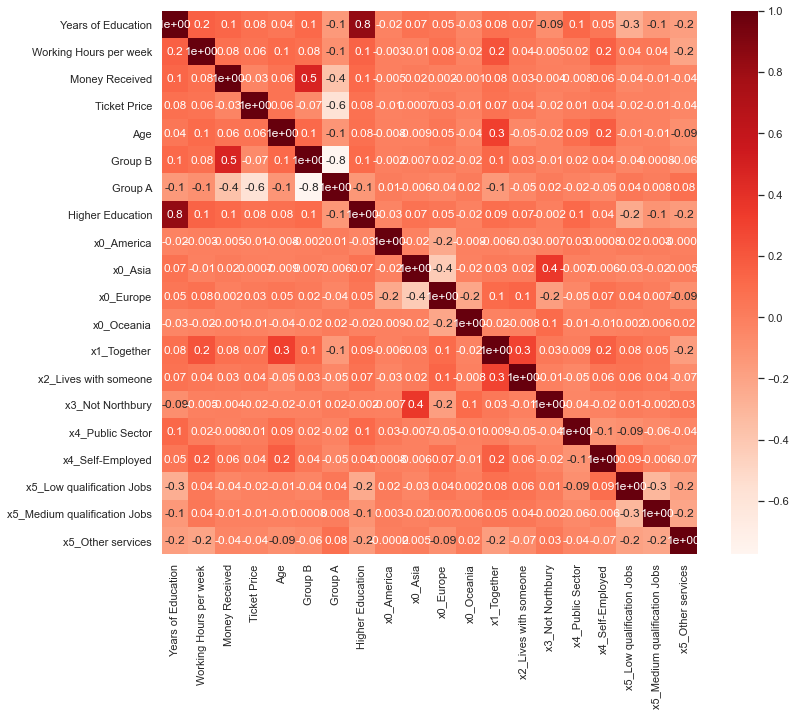

In [129]:
cor_pearson = X_train.corr()
cor_heatmap(cor_pearson) 

### 5.2. Spearman Correlation

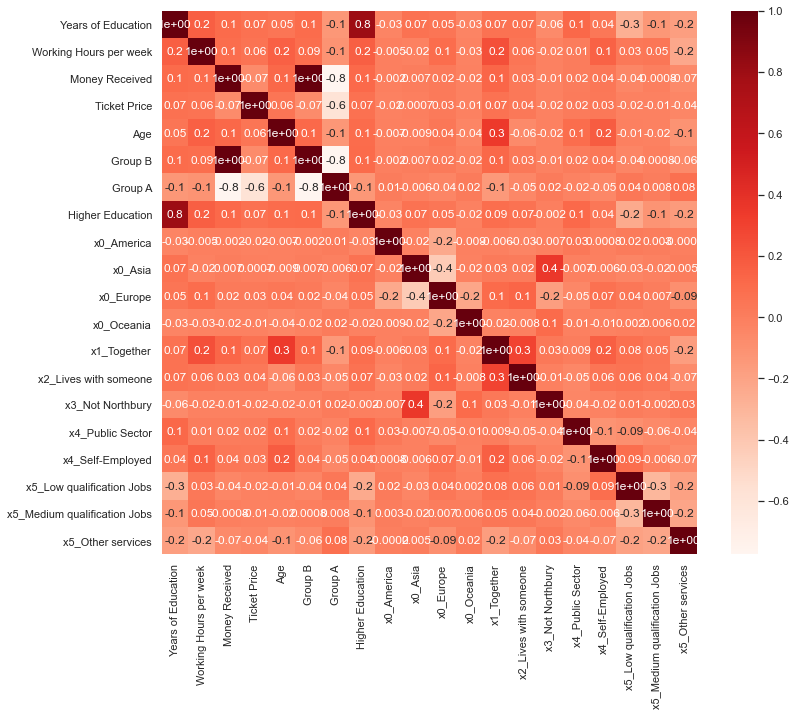

In [130]:
cor_spearman = X_train.corr(method ='spearman')
cor_heatmap(cor_spearman) 

### 5.3. Lasso Regression

In [131]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [132]:
reg = LassoCV()
reg.fit(X_train, y_train)
coef = pd.Series(reg.coef_, index=X_train.columns)
coef.sort_values()

x5_Low qualification Jobs      -0.105904
x5_Other services              -0.079434
x5_Medium qualification Jobs   -0.068217
x3_Not Northbury               -0.022971
x0_Asia                        -0.013783
x0_America                     -0.010637
x4_Self-Employed               -0.005411
x0_Oceania                     -0.000733
x4_Public Sector                0.003545
x2_Lives with someone           0.010078
x0_Europe                       0.020148
Higher Education                0.026914
Age                             0.034611
Money Received                  0.035300
Working Hours per week          0.036893
Male                            0.045433
Ticket Price                    0.078903
Years of Education              0.080180
Group A                         0.154953
x1_Together                     0.269658
Group B                         0.369323
dtype: float64

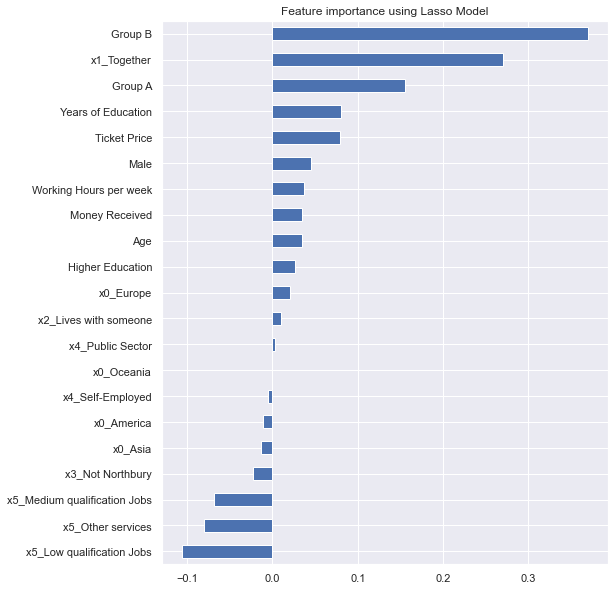

In [133]:
plot_importance(coef, 'Lasso')

### 5.4. Ridge Regression

In [134]:
ridge = RidgeCV()
ridge.fit(X_train, y_train)
coef_ridge = pd.Series(ridge.coef_, index=X_train.columns)
print(coef_ridge.sort_values())

x5_Low qualification Jobs      -0.107676
x5_Other services              -0.082038
x5_Medium qualification Jobs   -0.070039
x0_America                     -0.029373
x3_Not Northbury               -0.023109
x0_Oceania                     -0.021960
x0_Asia                        -0.021701
x4_Self-Employed               -0.007260
x4_Public Sector                0.004987
x2_Lives with someone           0.011069
x0_Europe                       0.017116
Higher Education                0.028423
Age                             0.034282
Money Received                  0.035276
Working Hours per week          0.036904
Male                            0.046277
Years of Education              0.079233
Ticket Price                    0.108999
x1_Together                     0.269992
Group A                         0.298025
Group B                         0.513445
dtype: float64


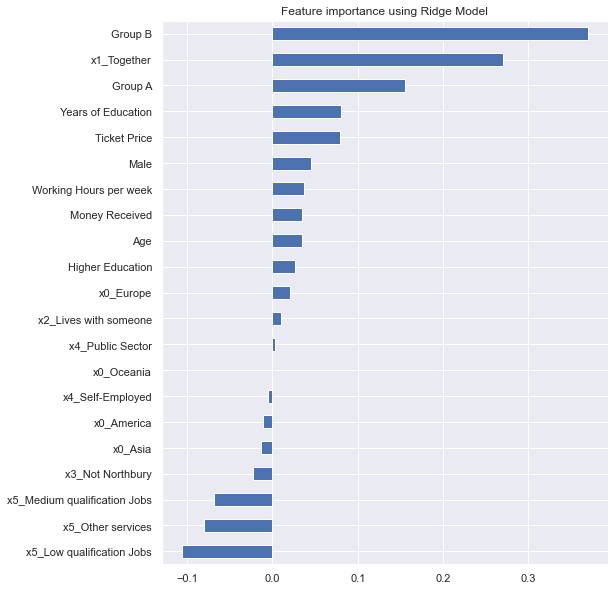

In [135]:
plot_importance(coef, 'Ridge')

### 5.5. Recursive Feature Elimination (RFE)

In [136]:
nof_list=np.arange(1,X_train.shape[1])
high_score=0
# Variable to store the optimum features
nof=0           
score_list =[]
for i in range(len(nof_list)):
    model = LogisticRegression()
    rfe = RFE(model, nof_list[i])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_val_rfe= rfe.transform(X_validation)
    model.fit(X_train_rfe,y_train)
    
    score = model.score(X_val_rfe,y_validation)
    score_list.append(score)
    
    if(score>high_score):
        high_score = score
        nof = nof_list[i]
        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 10
Score with 10 features: 0.843987


In [137]:
rfe = RFE(LogisticRegression(), nof)
X_train_rfe = rfe.fit_transform(X_train,y_train)
model.fit(X_train_rfe,y_train)

LogisticRegression()

In [138]:
selected_features = pd.Series(rfe.support_, index=X_train.columns)
selected_features

Years of Education               True
Working Hours per week          False
Money Received                   True
Ticket Price                     True
Age                             False
Male                            False
Group B                         False
Group A                          True
Higher Education                False
x0_America                       True
x0_Asia                         False
x0_Europe                       False
x0_Oceania                       True
x1_Together                      True
x2_Lives with someone           False
x3_Not Northbury                False
x4_Public Sector                False
x4_Self-Employed                False
x5_Low qualification Jobs        True
x5_Medium qualification Jobs     True
x5_Other services                True
dtype: bool

### 5.6. MIC

In [146]:
mutual = mutual_info_classif(X_train, y_train, discrete_features=True)

mic= dict(zip(X_train.columns, mutual))
mic

{'Years of Education': 0.06190204716311584,
 'Working Hours per week': 0.04100826741379776,
 'Money Received': 0.0831293340520135,
 'Ticket Price': 0.03866834940047752,
 'Age': 0.06848270140898989,
 'Male': 0.025836485392918426,
 'Group B': 0.02947111155720543,
 'Group A': 0.04064180716626217,
 'Higher Education': 0.045484517820834985,
 'x0_America': 0.00028320042592008647,
 'x0_Asia': 3.557941937659681e-05,
 'x0_Europe': 0.004606752683515403,
 'x0_Oceania': 0.0007467628234448047,
 'x1_Together': 0.10008496118273941,
 'x2_Lives with someone': 0.012614051175705812,
 'x3_Not Northbury': 0.000680891450486068,
 'x4_Public Sector': 0.001552754442251253,
 'x4_Self-Employed': 0.004905737142068267,
 'x5_Low qualification Jobs': 0.004978251614682044,
 'x5_Medium qualification Jobs': 0.0006823311950016342,
 'x5_Other services': 0.01894137392210352}

### 5.7. Weights of Dependent Variable on Binary Features

In [153]:
y_train_reset_index = y_train.reset_index().drop('CITIZEN_ID', axis = 1)
X_y_train = pd.concat([X_train,y_train_reset_index], axis = 1)

In [154]:
X_y_train.dtypes

Years of Education              float64
Working Hours per week          float64
Money Received                  float64
Ticket Price                    float64
Age                             float64
Male                             object
Group B                           int32
Group A                           int32
Higher Education                  int32
x0_America                      float64
x0_Asia                         float64
x0_Europe                       float64
x0_Oceania                      float64
x1_Together                     float64
x2_Lives with someone           float64
x3_Not Northbury                float64
x4_Public Sector                float64
x4_Self-Employed                float64
x5_Low qualification Jobs       float64
x5_Medium qualification Jobs    float64
x5_Other services               float64
Income                            int64
dtype: object

In [155]:
X_y_train_object_type = X_y_train.astype(str)

In [156]:
def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
                    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.ylabel("$Frequency$")

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")

    plt.show()

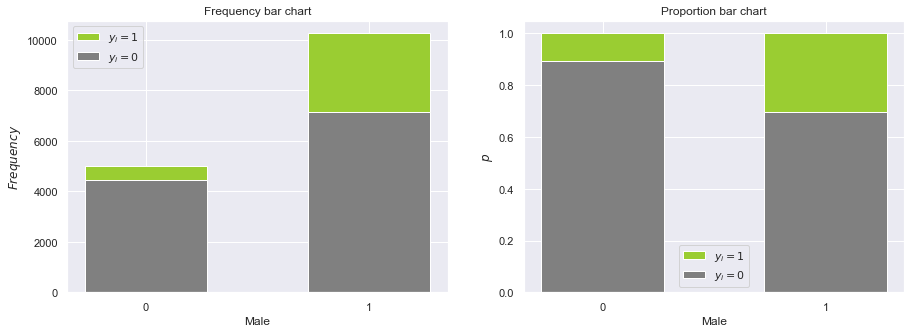

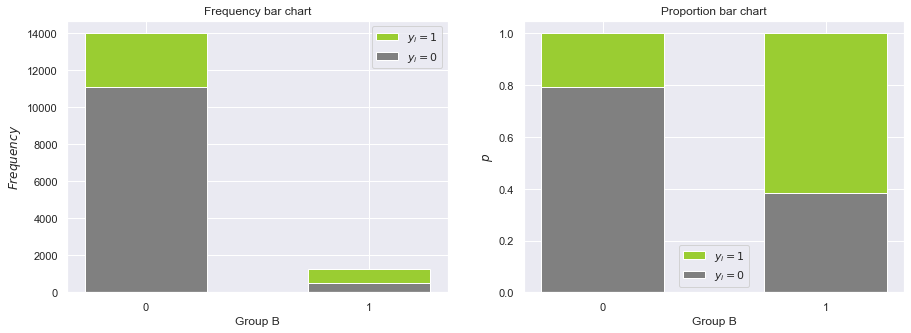

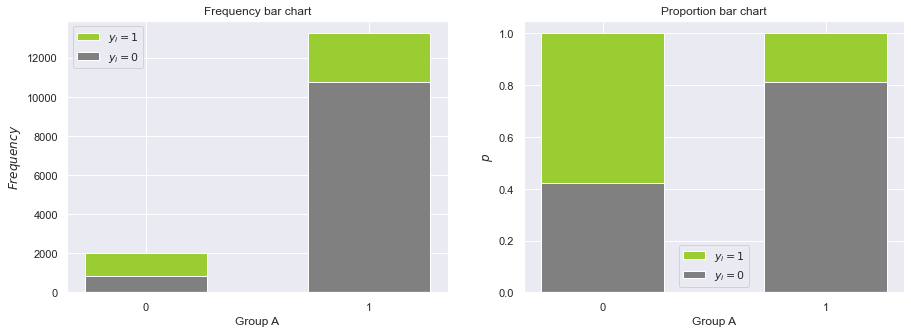

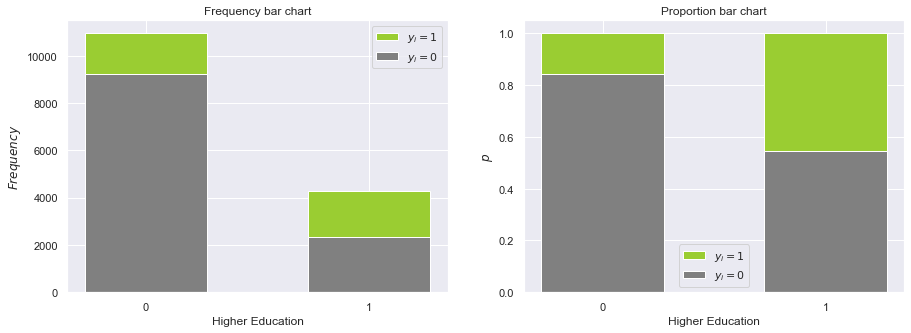

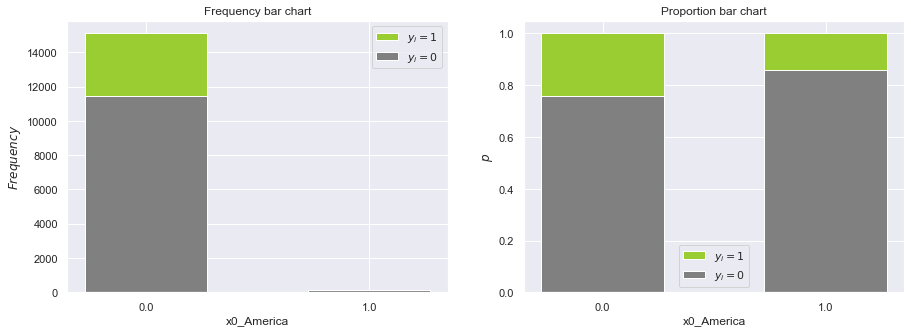

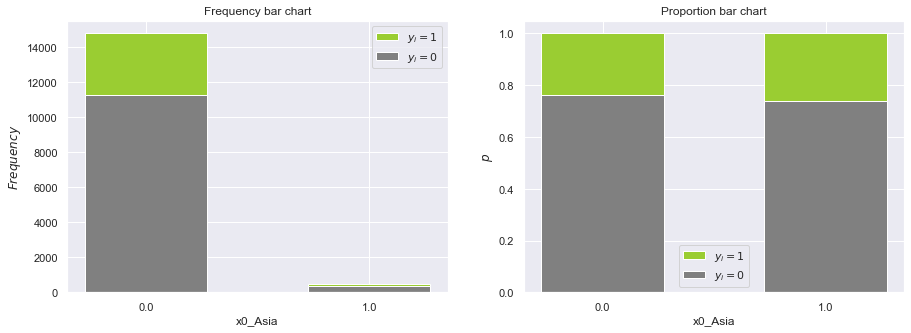

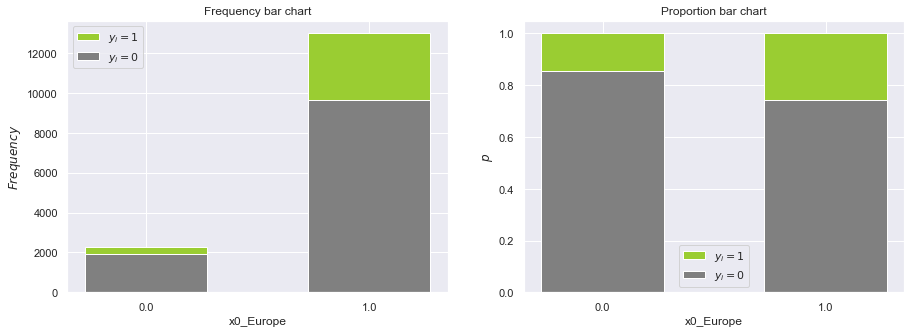

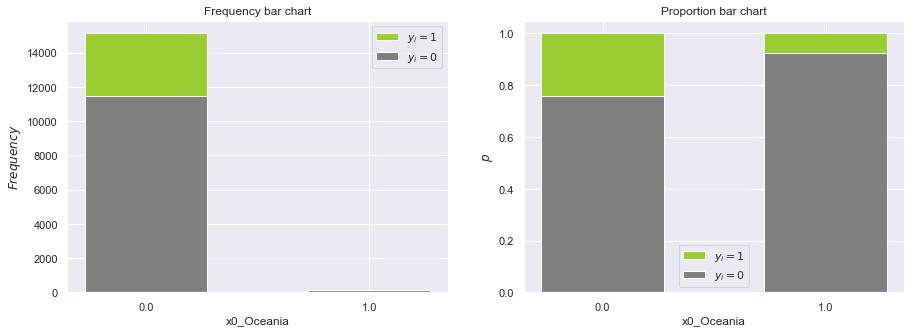

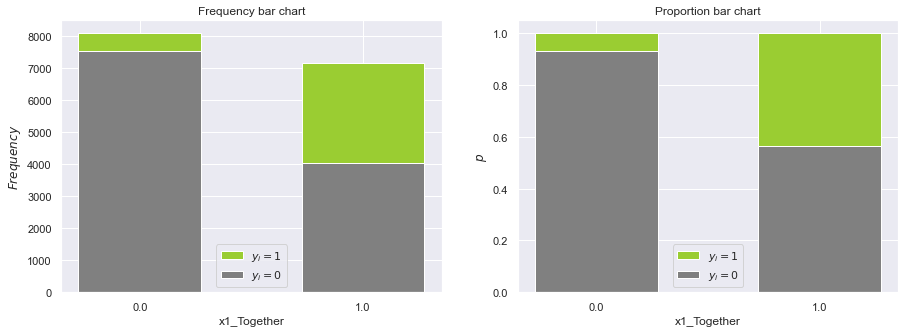

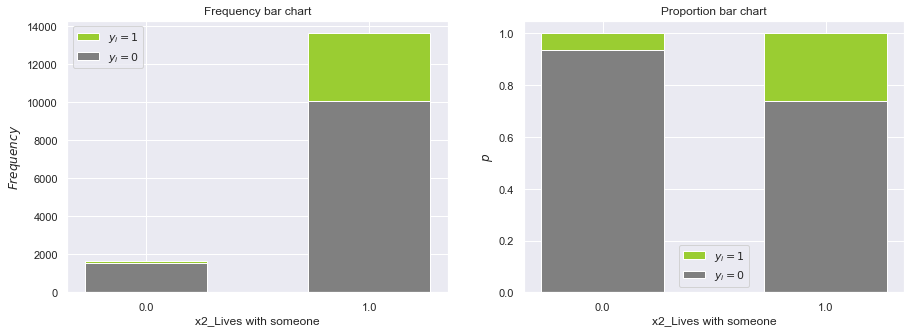

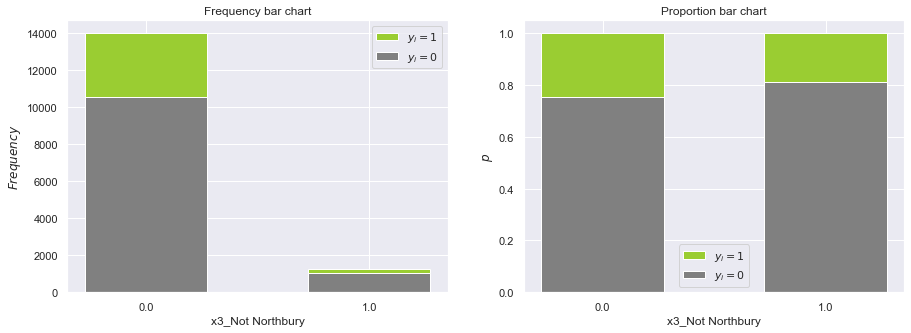

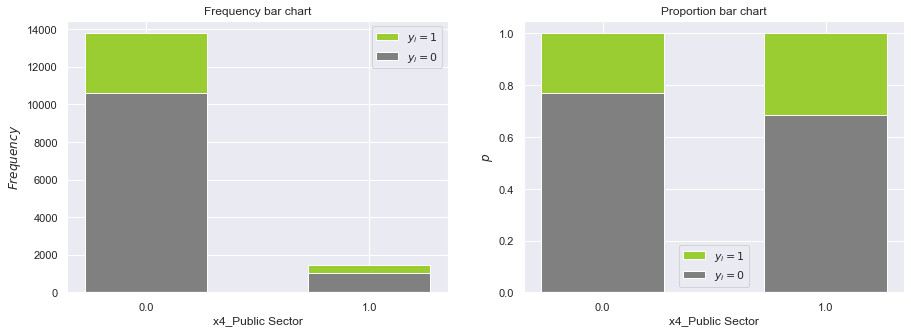

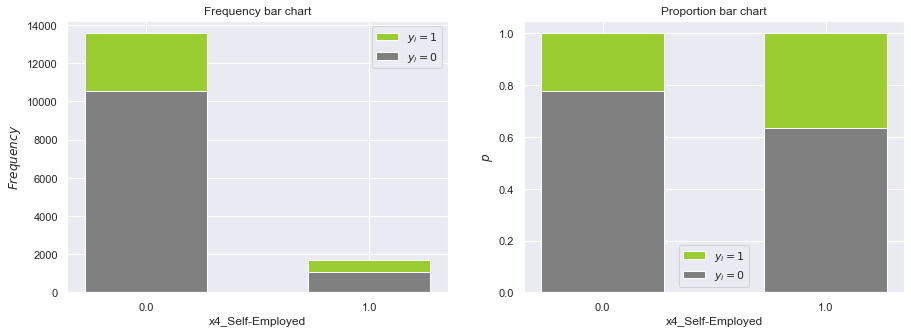

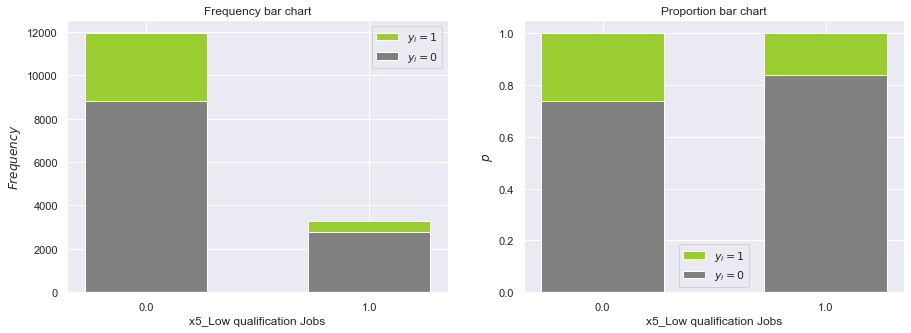

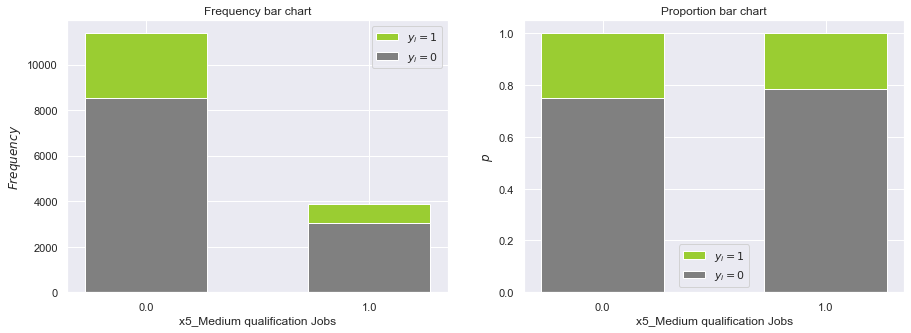

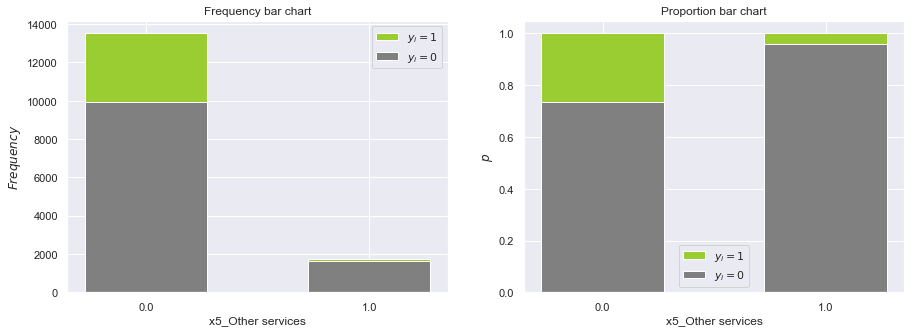

In [157]:
for i in range(len(binary_features)):
    bar_charts_categorical(X_y_train_object_type, binary_features[i], "Income")

### 5.8. Decision Tree - Feature Importance

In [158]:
gini_importance = DecisionTreeClassifier().fit(X_train, y_train).feature_importances_
entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(X_train, y_train).feature_importances_

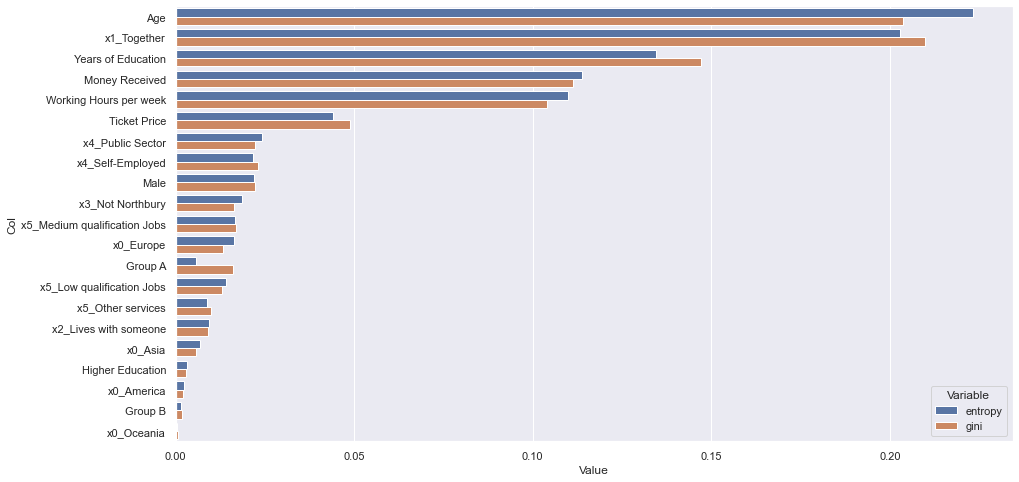

In [159]:
zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns = ['gini','entropy'])
zippy['col'] = X_train.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

## 6. Modelling

In [128]:
X_train.drop( columns=['Higher Education', 'Male', 'Group A', 'x0_Asia', 'x0_Europe','x2_Lives with someone', 'x3_Not Northbury',
       'x4_Public Sector','x4_Self-Employed','x5_Medium qualification Jobs'], inplace=True)

X_validation.drop( columns=['Higher Education', 'Male', 'Group A', 'x0_Asia', 'x0_Europe','x2_Lives with someone', 'x3_Not Northbury',
       'x4_Public Sector','x4_Self-Employed','x5_Medium qualification Jobs'], inplace=True)

test.drop( columns=['Higher Education', 'Male', 'Group A', 'x0_Asia', 'x0_Europe','x2_Lives with someone', 'x3_Not Northbury',
       'x4_Public Sector','x4_Self-Employed','x5_Medium qualification Jobs'], inplace=True)

#### Cross-Validation

In [129]:
def avg_score(model):
    method = RepeatedKFold(n_splits=4, n_repeats=8)
    
    y = y_train.append(y_validation)
    X = pd.concat([X_train, X_validation])

    score_train = []
    score_validation = []

    for train_index, test_index in method.split(X):
        X_train1, X_validation1 = X.iloc[train_index], X.iloc[test_index]
        y_train1, y_validation1 = y.iloc[train_index], y.iloc[test_index]
        fitted_model = model.fit(X_train1, y_train1)
        value_train = fitted_model.score(X_train1, y_train1)
        value_validation = fitted_model.score(X_validation1, y_validation1)
        score_train.append(value_train)
        score_validation.append(value_validation)

    print('TRAIN')
    print('Mean:', np.mean(score_train))
    print('Standard Deviation:', np.std(score_train))
    print('VALIDATION')
    print('Mean:', np.mean(score_validation))
    print('Standard Deviation:', np.std(score_validation))

In [130]:
def avg_score_train(model):
    method = RepeatedKFold(n_splits=4, n_repeats=8)
    
    y = y_train.append(y_validation)
    X = pd.concat([X_train, X_validation])

    score_train = []
    
    for train_index, test_index in method.split(X):
        X_train1, X_validation1 = X.iloc[train_index], X.iloc[test_index]
        y_train1, y_validation1 = y.iloc[train_index], y.iloc[test_index]
        fitted_model = model.fit(X_train1, y_train1)
        value_train = fitted_model.score(X_train1, y_train1)
        score_train.append(value_train)    
    
    return np.mean(score_train)

In [131]:
def avg_score_validation(model):
    method = RepeatedKFold(n_splits=4, n_repeats=8)
    
    y = y_train.append(y_validation)
    X = pd.concat([X_train, X_validation])

    score_validation = []

    for train_index, test_index in method.split(X):
        X_train1, X_validation1 = X.iloc[train_index], X.iloc[test_index]
        y_train1, y_validation1 = y.iloc[train_index], y.iloc[test_index]
        fitted_model = model.fit(X_train1, y_train1)
        value_validation = fitted_model.score(X_validation1, y_validation1)
        score_validation.append(value_validation)
    
    return np.mean(score_validation)

### 6.1 Linear Regression 

In [132]:
lin_model = LinearRegression().fit(X_train,y_train)

In [133]:
lin_model.score(X_train, y_train)

0.34940439850243643

In [134]:
lin_model.score(X_validation, y_validation)

0.3414312606069767

In [135]:
avg_score(lin_model)

TRAIN
Mean: 0.34734270480690704
Standard Deviation: 0.003378240782395394
VALIDATION
Mean: 0.3462773864738121
Standard Deviation: 0.01027951283880216


### 6.2 Logistic Regression

In [135]:
log_model = LogisticRegression().fit(X_train,y_train)

In [137]:
log_model.score(X_train, y_train)

0.8444663382594417

In [138]:
log_model.score(X_validation, y_validation)

0.8433914468782596

In [139]:
avg_score(log_model)

TRAIN
Mean: 0.8443255379285193
Standard Deviation: 0.0008183300447232842
VALIDATION
Mean: 0.8441203956965718
Standard Deviation: 0.002201019488981989


### 6.3 Neural Networks

In [141]:
# MLP=MLPClassifier()

#parameter_space = {
#     'hidden_layer_sizes': [(10,10,10), (20,30,20), (40,50,40)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adams'],
#     'learning_rate_init': list(np.linspace(0.00001,0.1,5)),
#     'learning_rate': ['constant','adaptive']
# }

# clf = GridSearchCV(MLP, parameter_space)
# clf.fit(X_train, y_train)
# clf.best_params_

In [132]:
MLP1 = MLPClassifier(hidden_layer_sizes=(120, 110, 100), activation='relu', solver='sgd', learning_rate='adaptive', 
                            learning_rate_init=0.17, batch_size=500, max_iter=700, alpha=0.5).fit(X_train, y_train)

In [143]:
MLP1.score(X_train, y_train)

0.8562889983579639

In [144]:
MLP1.score(X_validation, y_validation)

0.8509909104455372

In [133]:
MLP2 = MLPClassifier(hidden_layer_sizes=(100, 100, 100), activation='relu', solver='sgd', learning_rate='adaptive', 
                            learning_rate_init=0.2, batch_size=700, max_iter=500, alpha=0.5).fit(X_train, y_train)

In [146]:
MLP2.score(X_train, y_train)

0.8564203612479474

In [147]:
MLP2.score(X_validation, y_validation)

0.8530770376992997

In [133]:
MLP3 = MLPClassifier(hidden_layer_sizes=(120, 110, 100), activation='tanh', solver='sgd', learning_rate='adaptive', 
                            learning_rate_init=0.15, batch_size=500, max_iter=700, momentum=0.5).fit(X_train, y_train)

In [149]:
MLP3.score(X_train, y_train)

0.8526108374384237

In [150]:
MLP3.score(X_validation, y_validation)

0.8532260467888542

### 6.4 Decision Trees

In [151]:
def calculate_AUC(interval, X_train, X_validation, y_train, y_validation, parameter, max_depth = None):
    train_results = []
    validation_results = []
    for value in interval:
        if (parameter == 'depth'):          
            dt = DecisionTreeClassifier(max_depth = value)
            dt.fit(X_train, y_train)
        elif (parameter == 'features'):  
            dt = DecisionTreeClassifier(max_features = value, max_depth = max_depth)
            dt.fit(X_train, y_train)
        train_pred = dt.predict(X_train)
        roc_auc_valuetrain = roc_auc_score(y_train, train_pred, average = None, multi_class='ovr')
        # Add auc score to previous train results
        train_results.append(roc_auc_valuetrain)
        y_pred = dt.predict(X_validation)
        roc_auc_valueval = roc_auc_score(y_validation, y_pred, average='weighted', multi_class='ovr')
        # Add auc score to previous test results
        validation_results.append(roc_auc_valueval)
    value_train = train_results.index(max(train_results))
    value_validation = validation_results.index(max(validation_results))
    print('The best train value is ',interval[value_train])
    print('The best validation value is ',interval[value_validation])
    
    
    
    line1, = plt.plot(interval, train_results, 'b', label="Train AUC")
    line2, = plt.plot(interval, validation_results, 'r', label="Val AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel("ROC AUC score")
    plt.xlabel(str(parameter))
    plt.show()

The best train value is  15.0
The best validation value is  10.0


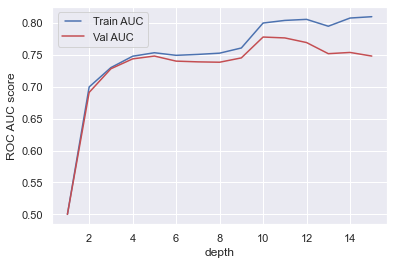

In [152]:
max_depths = np.linspace(1, 15, 15, endpoint=True)  
calculate_AUC(max_depths, X_train, X_validation , y_train, y_validation, 'depth')

The best train value is  10
The best validation value is  10


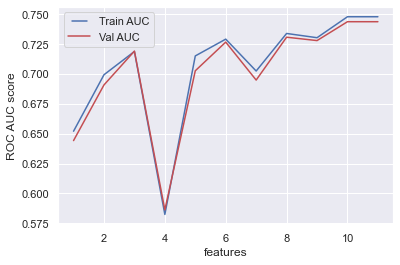

In [153]:
max_features = list(range(1,len(X_train.columns)+1))
calculate_AUC(max_features, X_train, X_validation, y_train, y_validation,'features', 10)

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

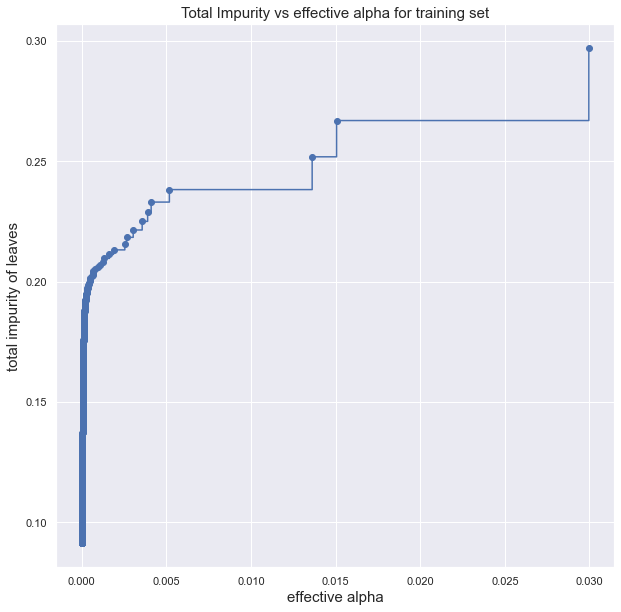

In [154]:
dt_alpha = DecisionTreeClassifier(random_state=0)
path = dt_alpha.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots(figsize = (10,10))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha", fontsize=15)
ax.set_ylabel("total impurity of leaves", fontsize=15)
ax.set_title("Total Impurity vs effective alpha for training set", fontsize=15)

In [155]:
# trees = []
# for ccp_alpha in ccp_alphas:
#     dt_alpha = DecisionTreeClassifier(random_state=None, ccp_alpha=ccp_alpha).fit(X_train, y_train)
#     trees.append(dt_alpha)
# print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(trees[-1].tree_.node_count, ccp_alphas[-1]))

In [156]:
# trees = trees[:-1]
# ccp_alphas = ccp_alphas[:-1]

# node_counts = [tree.tree_.node_count for tree in trees]
# depth = [tree.get_depth() for tree in trees]

# fig, ax = plt.subplots(2, 1, figsize=(20, 15))
# ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
# ax[0].set_xlabel("alpha", fontsize=15)
# ax[0].set_ylabel("number of nodes", fontsize=15)
# ax[0].set_title("Number of nodes vs alpha", fontsize=15)
# ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
# ax[1].set_xlabel("alpha", fontsize=15)
# ax[1].set_ylabel("depth of tree", fontsize=15)
# ax[1].set_title("Depth vs alpha", fontsize=15)
# fig.tight_layout()

In [157]:
# train_scores = [tree.score(X_train, y_train) for tree in trees]
# val_scores = [tree.score(X_validation, y_validation) for tree in trees]

# fig, ax = plt.subplots(figsize = (10,10))
# ax.set_xlabel("alpha", fontsize=15)
# ax.set_ylabel("accuracy", fontsize=15)
# ax.set_title("Accuracy vs alpha for training and testing sets")
# ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
# ax.plot(ccp_alphas, val_scores, marker='o', label="test", drawstyle="steps-post")
# ax.legend()
# plt.show()

In [158]:
# index_best_model = np.argmax(val_scores)
# best_model = trees[index_best_model]
# print('ccp_alpha of best model: ',trees[index_best_model])
# print('_____________________')
# print('Training accuracy of best model: ',best_model.score(X_train, y_train))
# print('Test accuracy of best model: ',best_model.score(X_validation, y_validation))

In [134]:
dt = DecisionTreeClassifier(ccp_alpha=0.00015859904832627716).fit(X_train, y_train)

In [160]:
dt.score(X_train, y_train)

0.8658128078817734

In [161]:
dt.score(X_validation, y_validation)

0.8568022649381613

### 6.5 K nearest Neighbors

In [137]:
knn = KNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=10, weights='uniform').fit(X_train, y_train)

In [163]:
knn.score(X_train, y_train)

0.8644334975369458

In [164]:
knn.score(X_validation, y_validation)

0.8383251378334078

In [165]:
#avg_score(knn)

In [166]:
knn2 = KNeighborsClassifier(algorithm='brute', metric='cosine', n_neighbors=10, weights='uniform').fit(X_train, y_train)

In [167]:
knn2.score(X_train, y_train)

0.8616091954022989

In [168]:
knn2.score(X_validation, y_validation)

0.8357919833109819

In [169]:
#avg_score(knn2)

#### 6.5.1 K Nearest Neighbor Tree 

In [135]:
KNNT = KNeighborsClassifier(n_neighbors = 50, weights = 'uniform', algorithm='kd_tree').fit(X_train, y_train)

In [171]:
KNNT.score(X_train, y_train)

0.8500492610837438

In [172]:
KNNT.score(X_validation, y_validation)

0.8429444196095962

In [173]:
#avg_score(KNNT)

#### 6.5.2 K Nearest Neighbor Ball Tree

In [136]:
KNNBT = KNeighborsClassifier(n_neighbors = 50, weights = 'uniform', algorithm='ball_tree').fit(X_train, y_train)

In [175]:
KNNBT.score(X_train, y_train)

0.8491297208538587

In [176]:
KNNBT.score(X_validation, y_validation)

0.8432424377887051

In [177]:
#avg_score(KNNBT)

### 6.6 K Nearest Centroids 

In [178]:
RepKFold= RepeatedKFold(n_splits=4, n_repeats=8)

In [179]:
# knc_clf = NearestCentroid()

# knc_parameters = {'metric' : ['euclidean', 'cosine', 'manhattan']}

# knc_grid = GridSearchCV(estimator=knc_clf, param_grid=knc_parameters, cv=RepKFold , scoring='accuracy', n_jobs=-1)

# knc_grid.fit(X_train, y_train)

# knc_grid.best_params_

In [180]:
knc = NearestCentroid(metric='euclidean').fit(X_train, y_train)

In [181]:
knc.score(X_train, y_train)

0.7833169129720854

In [182]:
knc.score(X_validation, y_validation)

0.7822977201609298

In [183]:
avg_score(knc)

TRAIN
Mean: 0.7811227358375881
Standard Deviation: 0.002469783116551081
VALIDATION
Mean: 0.7807827315827862
Standard Deviation: 0.007431747484536064


### 6.7 Passive Agressive

In [184]:
pa = PassiveAggressiveClassifier(class_weight=None, early_stopping=False, max_iter=100, warm_start=True, random_state=15).fit(X_train, y_train)

In [185]:
pa.score(X_train, y_train)

0.8233169129720854

In [186]:
pa.score(X_validation, y_validation)

0.8199970198182089

In [187]:
avg_score(pa)

TRAIN
Mean: 0.7865855974957452
Standard Deviation: 0.04114557148765087
VALIDATION
Mean: 0.7857973194748358
Standard Deviation: 0.04265196032693834


### 6.9 Naive Bayes

In [188]:
NB = GaussianNB(var_smoothing=0.3).fit(X_train, y_train)

In [189]:
NB.score(X_train, y_train)

0.7991461412151067

In [190]:
NB.score(X_validation, y_validation)

0.7982416927432573

In [191]:
avg_score(NB)

TRAIN
Mean: 0.7982236202285437
Standard Deviation: 0.001584786930818761
VALIDATION
Mean: 0.7981856309263311
Standard Deviation: 0.005426404481190383


### 6.10 Support Vector Machine

In [192]:
# svm_clf = SVC(class_weight=None , kernel='poly',random_state=15, decision_function_shape = 'ovr')

# svm_parameters = {
#     'tol' : list(np.linspace(0.000001,0.00005, 1, 10)),
#     'degree': [2, 4],
#     'gamma' : ['scale', 'auto'],
#     'C' : np.arange(11, 30, 5)
# }

# svm_grid = GridSearchCV(estimator= svm_clf, param_grid=svm_parameters, scoring='accuracy', n_jobs=-1)
# svm_grid.fit(X_train, y_train)
# print("Best Score: ", svm_grid.best_score_)
# print("Best MLP: ", svm_grid.best_estimator_)

In [137]:
svm = SVC(C=11, class_weight=None, degree=2, gamma='auto', kernel='poly', probability=False, random_state=15, tol=1e-06).fit(X_train, y_train)

In [194]:
svm.score(X_train, y_train)

0.8480788177339902

In [195]:
svm.score(X_validation, y_validation)

0.8450305468633587

In [196]:
#avg_score(svm)

### 6.11 Comparing the average scores of the best models

In [184]:
scores_train = [avg_score_train(MLP1), 
                avg_score_train(MLP2), 
                avg_score_train(MLP3), 
                avg_score_train(dt), 
                avg_score_train(KNNT), 
                avg_score_train(KNNBT),
                avg_score_train(svm)]

scores_validation = [avg_score_validation(MLP1),
                     avg_score_validation(MLP2),
                     avg_score_validation(MLP3),
                     avg_score_validation(dt), 
                     avg_score_validation(KNNT), 
                     avg_score_validation(KNNBT),
                     avg_score_validation(svm)]

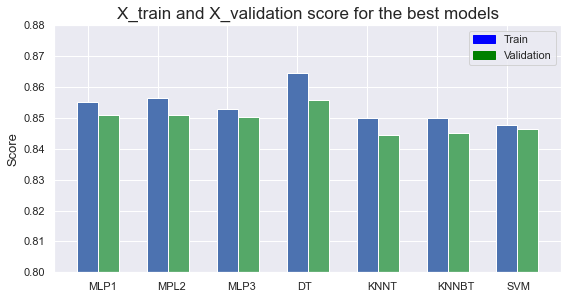

In [187]:
models_names = ['MLP1', 'MPL2', 'MLP3', 'DT', 'KNNT', 'KNNBT', 'SVM']

figure = plt.figure(figsize=(20,10))
ax = figure.add_subplot(222)

ax.bar(np.arange(0,len(models_names)) , scores_train, width=0.3, color='b', align='center')
ax.bar(np.arange(0,len(models_names)) + 0.3, scores_validation, width=0.3, color='g', align='center')

ax.set_xticks(np.arange(len(models_names)))
ax.set_xticklabels(models_names, ha='left')

plt.title('X_train and X_validation score for the best models', fontdict = {'fontsize': 17})
plt.ylabel('Score', fontdict = {'fontsize': 13})
plt.ylim(0.8,0.88)

colors = {'Train':'Blue', 'Validation':'Green'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.show()

## 7. Ensemble

### 7.1. Bagging Classifier

In [ ]:
# bagging = BaggingClassifier()

# bagging_parameters = {'base_estimator' : [KNNBT, dt, KNNT, svm, MLP3],
#                   'n_estimators' : np.arange(10,50,10),
#                   'bootstrap' : [True, False],
#                   #'bootstrap_features' : [True, False],
#                   'warm_start' : [True, False]}

# bagging_grid = GridSearchCV(estimator=bagging, param_grid=bagging_parameters, cv=RepKFold, scoring='accuracy', n_jobs=-1)
# bagging_grid.fit(X_train, y_train)
# bagging_grid.best_params_

In [138]:
bagging = BaggingClassifier(base_estimator= dt , n_estimators=10, bootstrap=True, bootstrap_features=True, 
                               warm_start=True, random_state=15).fit(X_train, y_train)

In [229]:
bagging.score(X_train, y_train)

0.8630757118488387

In [230]:
bagging.score(X_validation, y_validation)

0.8527790195201908

In [230]:
avg_score(bagging)

TRAIN
Mean: 0.8581065662668781
Standard Deviation: 0.0015055836913786466
VALIDATION
Mean: 0.8581065507048931
Standard Deviation: 0.004516666193798244


In [231]:
bagging1 = BaggingClassifier(base_estimator= KNNBT , n_estimators=10, bootstrap=True, bootstrap_features=True, 
                               warm_start=True, random_state=15).fit(X_train, y_train)

In [233]:
bagging1.score(X_train, y_train)

0.8457446808510638

In [234]:
bagging1.score(X_validation, y_validation)

0.8404112650871703

In [304]:
avg_score(bagging1)

TRAIN
Mean: 0.8441132249970886
Standard Deviation: 0.0014914659615762442
VALIDATION
Mean: 0.8441132407560703
Standard Deviation: 0.004474520843621548


In [305]:
bagging2 = BaggingClassifier(base_estimator= KNNT , n_estimators=10, bootstrap=True, bootstrap_features=True, 
                               warm_start=True, random_state=15).fit(X_train, y_train)

In [237]:
bagging2.score(X_train, y_train)

0.8457446808510638

In [238]:
bagging2.score(X_validation, y_validation)

0.8398152287289524

In [306]:
avg_score(bagging2)

TRAIN
Mean: 0.8439308898546364
Standard Deviation: 0.0011412958636775204
VALIDATION
Mean: 0.8439308141875561
Standard Deviation: 0.0034241310803847075


In [131]:
bagging3 = BaggingClassifier(base_estimator= MLP3 , n_estimators=10, bootstrap=True, bootstrap_features=True, 
                               warm_start=True, random_state=15).fit(X_train, y_train)

In [240]:
bagging3.score(X_train, y_train)

0.8469923824533754

In [241]:
bagging3.score(X_validation, y_validation)

0.8441364923260319

In [307]:
avg_score(bagging3)

TRAIN
Mean: 0.8461187876031064
Standard Deviation: 0.0014964071778534424
VALIDATION
Mean: 0.8461188172254814
Standard Deviation: 0.0044891324281639885


In [242]:
bagging4 = BaggingClassifier(base_estimator= MLP2 , n_estimators=10, bootstrap=True, bootstrap_features=True, 
                               warm_start=True, random_state=15).fit(X_train, y_train)

In [243]:
bagging4.score(X_train, y_train)

0.8473863934856842

In [244]:
bagging4.score(X_validation, y_validation)

0.8421993741618239

In [308]:
avg_score(bagging4)

TRAIN
Mean: 0.845799730449321
Standard Deviation: 0.0013661203834576506
VALIDATION
Mean: 0.845799834872243
Standard Deviation: 0.004098335793444243


In [245]:
bagging5 = BaggingClassifier(base_estimator= MLP1 , n_estimators=10, bootstrap=True, bootstrap_features=True, 
                               warm_start=True, random_state=15).fit(X_train, y_train)

In [246]:
bagging5.score(X_train, y_train)

0.8459416863672183

In [247]:
bagging5.score(X_validation, y_validation)

0.8424973923409328

In [309]:
avg_score(bagging5)

TRAIN
Mean: 0.8448881136012013
Standard Deviation: 0.0014707280644552195
VALIDATION
Mean: 0.8448882318713526
Standard Deviation: 0.004412216229228257


### 7.2. Random Forest

In [ ]:
# rf_clf = RandomForestClassifier()

# rf_parameters = {"n_estimators": np.arange(100, 400, 100),
#                   "max_features": ['sqrt', 'log2', 'auto', None],
#                   "criterion": ['gini', 'entropy'],
#                   "warm_start" : [True, False]}

# rf_grid = GridSearchCV(estimator=rf_clf, param_grid=rf_parameters, cv=RepKFold, scoring='accuracy', n_jobs=-1)

# rf_grid.fit(X_train, y_train)
# rf_grid.best_params_

In [139]:
rf = RandomForestClassifier(criterion='entropy', max_features= 'sqrt' , n_estimators=300 ,warm_start=False ,random_state=15, ccp_alpha=0.001).fit(X_train, y_train)

In [234]:
rf.score(X_train, y_train)

0.8534969164151686

In [235]:
rf.score(X_validation, y_validation)

0.849649828639547

In [267]:
avg_score(rf)

TRAIN
Mean: 0.8568037131694681
Standard Deviation: 0.0012164932695288607
VALIDATION
Mean: 0.8543974345356709
Standard Deviation: 0.003771899891838957


In [279]:
rf1 = RandomForestClassifier(criterion='gini', max_features= 'sqrt' , n_estimators=150 ,warm_start=False ,random_state=15, ccp_alpha=0.001).fit(X_train, y_train)

In [280]:
rf1.score(X_train, y_train)

0.8557919621749409

In [281]:
rf1.score(X_validation, y_validation)

0.8478617195648934

In [268]:
avg_score(rf1)

TRAIN
Mean: 0.8535104950333069
Standard Deviation: 0.0016618222124517323
VALIDATION
Mean: 0.8524488773423573
Standard Deviation: 0.004752861720867266


In [132]:
rf3 = RandomForestClassifier(criterion='entropy', max_features= 'log2' , n_estimators=300 ,warm_start=False ,random_state=15, ccp_alpha=0.001).fit(X_train, y_train)

In [286]:
rf3.score(X_train, y_train)

0.8592723929603362

In [287]:
rf3.score(X_validation, y_validation)

0.8523319922515273

In [296]:
avg_score(rf3)

TRAIN
Mean: 0.8569138745257304
Standard Deviation: 0.0012619542895093033
VALIDATION
Mean: 0.8546709429669272
Standard Deviation: 0.0038033056128363696


In [264]:
rf5 = RandomForestClassifier(criterion='gini', max_features= 'log2' , n_estimators=150 ,warm_start=False ,random_state=15, ccp_alpha=0.001).fit(X_train, y_train)

In [265]:
rf5.score(X_train, y_train)

0.8557919621749409

In [266]:
rf5.score(X_validation, y_validation)

0.8478617195648934

In [272]:
avg_score(rf5)

TRAIN
Mean: 0.8536776206048247
Standard Deviation: 0.0017134119735536827
VALIDATION
Mean: 0.8521980908079657
Standard Deviation: 0.0039349714260636815


### 7.3. AdaBoost Classifier

In [237]:
# Ada_Boost = AdaBoostClassifier()
# Ada_Boost_parameter_space = {'base_estimator' : [dt, svm, rf],
#                              'n_estimators': list(np.arange(20,150,15)),
#                              'algorithm' : ['SAMME', 'SAMME.R'],
#                              'learning_rate': list(np.arange(0.1,1,0.1))}
# Ada_Boost_Grid = GridSearchCV(estimator=Ada_Boost, param_grid=Ada_Boost_parameter_space, cv=RepKFold, scoring='accuracy', verbose=1, n_jobs=-1)
# Ada_Boost_Grid.fit(X_train, y_train)
# Ada_Boost_Grid.best_params_

In [140]:
Ada_Boost = AdaBoostClassifier(base_estimator = dt, learning_rate = 0.021, n_estimators = 35, algorithm = 'SAMME', random_state = 5).fit(X_train, y_train)

In [771]:
Ada_Boost.score(X_train, y_train)

0.8717040535222353

In [772]:
Ada_Boost.score(X_validation, y_validation)

0.8602294739979138

In [773]:
avg_score(Ada_Boost)

TRAIN
Mean: 0.8699693305118861
Standard Deviation: 0.0012744324827968876
VALIDATION
Mean: 0.8599478203799551
Standard Deviation: 0.003315038956372087


In [242]:
Ada_Boost2 = AdaBoostClassifier(base_estimator = rf , learning_rate = 0.021, n_estimators = 35, algorithm = 'SAMME', random_state = 5).fit(X_train, y_train)

In [243]:
Ada_Boost2.score(X_train, y_train)

0.8580894895682981

In [246]:
Ada_Boost2.score(X_validation, y_validation)

0.8597824467292505

In [205]:
avg_score(Ada_Boost2)

TRAIN
Mean: 0.8582801580066849
Standard Deviation: 0.0016444921455770042
VALIDATION
Mean: 0.856130355515041
Standard Deviation: 0.004739707480842363


### 7.4. Voting Classifier

In [ ]:
# voting_clf = VotingClassifier(estimators= [('KNNBT', KNNBT), ('dt', dt), ('rf', rf), ('svm', svm)])

# voting_parameters = {
#                       'voting' : ['hard', 'soft'],
#                       'weights': [None, 0.5, 1],
#                        'n_jobs': [None, 0, -1],
#                       'flatten_transform' : [True, False],
#                       'verbose' : [True, False]}


# voting_clf = GridSearchCV(estimator=voting_clf, param_grid=voting_parameters, scoring='accuracy').fit(X_train, y_train)
# voting_clf.best_params_

In [141]:
voting_clf = VotingClassifier(estimators=[('KNNBT', KNNBT), ('dt', dt), ('MLP3', MLP3)], voting='soft', weights=None, n_jobs=None, flatten_transform=True).fit(X_train, y_train)

In [152]:
avg_score(voting_clf)

TRAIN
Mean: 0.8625685340070345
Standard Deviation: 0.001599434806344374
VALIDATION
Mean: 0.8567344613002025
Standard Deviation: 0.0032860149710186443


In [153]:
voting_clf1 = VotingClassifier(estimators=[('rf', rf), ('dt', dt), ('MLP3', MLP3)], voting='soft', weights=None, n_jobs=None, flatten_transform=True).fit(X_train, y_train)

In [154]:
avg_score(voting_clf1)

TRAIN
Mean: 0.8619059593700358
Standard Deviation: 0.0015797078180469876
VALIDATION
Mean: 0.8564553552190206
Standard Deviation: 0.004528274860676494


### 7.5. Gradient Boosting Classifier

In [ ]:
# Grad_Boost = GradientBoostingClassifier(random_state = 5)

# Grad_Boost_Parameters = {'loss' : ['deviance', 'exponential'],
#                          'learning_rate' : (0.01, 0.1, 0.4),
#                          'n_estimators' : (100, 300, 500),
#                          'max_features' : [8, 'log2', None],
#                          'max_depth' : (5, 10, 15),
#                          'warm_start' : [True, False]}

# Grad_Boost = GridSearchCV(estimator=Grad_Boost, param_grid=Grad_Boost_Parameters, scoring='accuracy', n_jobs=-1).fit(X_train, y_train)
# Grad_Boost.best_params_

In [811]:
Grad_Boost = GradientBoostingClassifier(learning_rate = 0.1, loss = 'deviance', max_depth = 5, max_features = None,
                                       n_estimators = 100, warm_start = True, random_state = 5).fit(X_train, y_train)

In [812]:
avg_score(Grad_Boost)

TRAIN
Mean: 0.870291932993035
Standard Deviation: 0.0012578647666865916
VALIDATION
Mean: 0.8702919230579058
Standard Deviation: 0.0037737005068105766


In [142]:
Grad_Boost1 = GradientBoostingClassifier(learning_rate = 0.2, loss = 'deviance', max_depth = 5, max_features = None,
                                       n_estimators = 100, warm_start = True, random_state = 5).fit(X_train, y_train)

In [784]:
avg_score(Grad_Boost1)

TRAIN
Mean: 0.8760759589707381
Standard Deviation: 0.0016252496689073482
VALIDATION
Mean: 0.8760758974481502
Standard Deviation: 0.004875801936417234


In [813]:
Grad_Boost2 = GradientBoostingClassifier(learning_rate = 0.2, loss = 'deviance', max_depth = 5, max_features = None,
                                       n_estimators = 120, warm_start = True, random_state = 5).fit(X_train, y_train)

In [814]:
avg_score(Grad_Boost2)

TRAIN
Mean: 0.8781254245818759
Standard Deviation: 0.0012741839039684586
VALIDATION
Mean: 0.8781254054723124
Standard Deviation: 0.0038224870676086546


In [143]:
Grad_Boost11 = GradientBoostingClassifier(learning_rate = 0.15, loss = 'deviance', max_depth = 10, max_features = None,
                                       n_estimators = 200, warm_start = True, random_state = 5).fit(X_train, y_train)

In [794]:
avg_score(Grad_Boost11)

TRAIN
Mean: 0.9004873200823815
Standard Deviation: 0.0011283744876791017
VALIDATION
Mean: 0.9004873517941663
Standard Deviation: 0.003385148824236693


### 7.6. Stacking Classifier

In [158]:
estimators=[(' KNNBT',  KNNBT), ('rf', rf), ('dt', dt), ('svm', svm),('MLP1', MLP1)]

In [159]:
sc = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()).fit(X_train, y_train)

In [160]:
sc.score(X_train, y_train)

0.861315305854555

In [161]:
sc.score(X_validation, y_validation)

0.8593354194605871

In [144]:
estimators3=[('Grad_Boost',  Grad_Boost11), ('rf', rf), ('voting_clf', voting_clf),('Ada_Boost', Ada_Boost) ,('bagging', bagging)]

In [147]:
sc3 = StackingClassifier(estimators=estimators3, final_estimator=LogisticRegression(), n_jobs = -1).fit(X_train, y_train)

In [148]:
sc3.score(X_train, y_train)

0.8778135048231511

In [149]:
sc3.score(X_validation, y_validation)

0.8633586648785576

In [150]:
sc6 = StackingClassifier(estimators=estimators3, final_estimator=MLPClassifier(), n_jobs = -1).fit(X_train, y_train)

In [151]:
sc6.score(X_train, y_train)

0.8793227902093314

In [152]:
sc6.score(X_validation, y_validation)

0.8648487557741023

### 7.7. Comparing the average scores of the best Ensemble models

In [189]:
scores_train_ensemble = [avg_score_train(bagging), 
                         avg_score_train(Ada_Boost), 
                         avg_score_train(voting_clf),
                         avg_score_train(voting_clf2),
                         avg_score_train(Grad_Boost),
                         avg_score_train(Grad_Boost1),
                         avg_score_train(Grad_Boost11),
                         avg_score_train(sc6)]

scores_validation_ensemble = [avg_score_validation(bagging),
                              avg_score_validation(Ada_Boost),
                              avg_score_validation(voting_clf),
                              avg_score_validation(voting_clf2), 
                              avg_score_validation(Grad_Boost), 
                              avg_score_validation(Grad_Boost1),
                              avg_score_validation(Grad_Boost11),
                              avg_score_validation(sc6)]

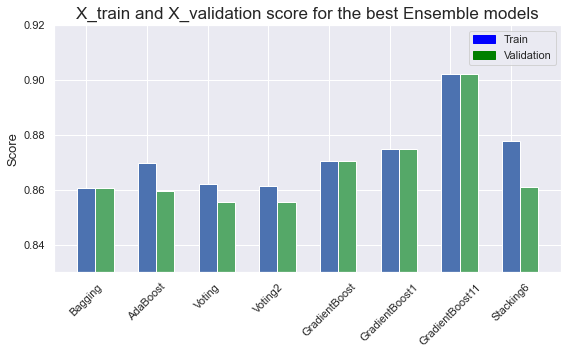

In [190]:
ensembles_names = ['Bagging','AdaBoost','Voting', 'Voting2','GradientBoost','GradientBoost1','GradientBoost11','Stacking6']

figure = plt.figure(figsize=(20,10))
ax = figure.add_subplot(222)

ax.bar(np.arange(0,len(ensembles_names)) , scores_train_ensemble, width=0.3, color='b', align='center')
ax.bar(np.arange(0,len(ensembles_names)) + 0.3, scores_validation_ensemble, width=0.3, color='g', align='center')

ax.set_xticks(np.arange(len(ensembles_names)))
ax.set_xticklabels(ensembles_names, rotation = 45)

plt.title('X_train and X_validation score for the best Ensemble models', fontdict = {'fontsize': 17})
plt.ylabel('Score', fontdict = {'fontsize': 13})
plt.ylim(0.83,0.92)

colors = {'Train':'Blue', 'Validation':'Green'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.show()

## 8. Results 

In [778]:
test.set_index('CITIZEN_ID', inplace = True)

### 8.1. Grad Boosting

In [815]:
Test_Grad_Boost= test.copy()

In [816]:
Test_Grad_Boost['Income'] = Grad_Boost.predict(Test_Grad_Boost)

In [817]:
final_test_Grad_Boost = pd.DataFrame(Test_Grad_Boost['Income'])

In [818]:
final_test_Grad_Boost.to_csv("Grad_Boost.csv")

### 8.2. Grad Boosting 1

In [ ]:
Test_Grad_Boost1= test.copy()

In [ ]:
Test_Grad_Boost1['Income'] = Grad_Boost1.predict(Test_Grad_Boost1)

In [ ]:
final_test_Grad_Boost1 = pd.DataFrame(Test_Grad_Boost1['Income'])

In [ ]:
final_test_Grad_Boost1.to_csv("Grad_Boost1.csv")

### 8.3. Grad Boosting 2

In [819]:
Test_Grad_Boost2= test.copy()

In [820]:
Test_Grad_Boost2['Income'] = Grad_Boost2.predict(Test_Grad_Boost2)

In [821]:
final_test_Grad_Boost2 = pd.DataFrame(Test_Grad_Boost2['Income'])

In [822]:
final_test_Grad_Boost2.to_csv("Grad_Boost2.csv")

### 8.4. Stacking

In [ ]:
Test_Stacking= test.copy()

In [ ]:
Test_Stacking['Income'] = sc.predict(Test_Stacking)

In [ ]:
final_test_stacking= pd.DataFrame(Test_Stacking['Income'])

In [ ]:
final_test_stacking.to_csv("sc.csv")

### 8.5. Stacking 3

In [ ]:
Test_Stacking3= test.copy()

In [ ]:
Test_Stacking3['Income'] = sc3.predict(Test_Stacking3)

In [ ]:
final_test_stacking3 = pd.DataFrame(Test_Stacking3['Income'])

In [ ]:
final_test_stacking3.to_csv("sc3.csv")

### 8.6. Stacking 6

In [ ]:
Test_Stacking6 = test.copy()

In [ ]:
Test_Stacking6['Income'] = sc6.predict(Test_Stacking6)

In [ ]:
final_test_stacking6= pd.DataFrame(Test_Stacking6['Income'])

In [ ]:
final_test_stacking6.to_csv("sc6.csv")

### 8.7. Voting 

In [ ]:
Test_Voting= test.copy()

In [ ]:
Test_Voting['Income'] = voting_clf.predict(Test_Voting)

In [ ]:
final_test_voting= pd.DataFrame(Test_Voting['Income'])

In [ ]:
final_test_voting.to_csv("voting.csv")

### 8.8. Voting 1

In [ ]:
Test_Voting1 = test.copy()

In [2]:
Test_Voting1['Income'] = voting_clf2.predict(Test_Voting1)

In [ ]:
final_test_voting1= pd.DataFrame(Test_Voting1['Income'])

In [ ]:
final_test_voting1.to_csv("voting1.csv")

### 8.9. AdaBoost

In [779]:
Test_AdaBoost = test.copy()

In [780]:
Test_AdaBoost['Income'] =  Ada_Boost.predict(Test_AdaBoost)

In [781]:
final_test_AdaBoost = pd.DataFrame(Test_AdaBoost['Income'])

In [782]:
final_test_AdaBoost.to_csv("Ada_Boost.csv")

### 8.10. AdaBoost 2

In [ ]:
Test_AdaBoost2 = test.copy()

In [ ]:
Test_AdaBoost2['Income']= Ada_Boost2.predict(Test_AdaBoost2)

In [ ]:
final_test_AdaBoost2 = pd.DataFrame(Test_AdaBoost2['Income'])

In [ ]:
final_test_AdaBoost2.to_csv("Ada_Boost2.csv")

### 8.11. Neural Networks 2

In [ ]:
Test_MLP2 = test.copy()

In [ ]:
Test_MLP2['Income'] = MLP2.predict(Test_MLP2)

In [ ]:
final_test_MLP2= pd.DataFrame(Test_MLP2['Income'])

In [ ]:
final_test_MLP2.to_csv("MLP2.csv")

### 8.12. Decision Trees

In [ ]:
Test_dt = test.copy()

In [ ]:
Test_dt['Income'] = dt.predict(Test_dt)

In [ ]:
final_test_dt= pd.DataFrame(Test_dt['Income'])

In [ ]:
final_test_dt.to_csv("dt.csv")

### 9. Model Assesment

In [157]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('____________________________________________________________')
    print(' TRAIN ')
    print('------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))
    print('____________________________________________________________')
    print(' VALIDATION ')
    print('------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))

labels_train = Grad_Boost1.predict(X_train)

labels_val = Grad_Boost1.predict(X_validation)

metrics(y_train, labels_train, y_validation, labels_val)

____________________________________________________________
 TRAIN 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.95      0.93     11579
           1       0.81      0.67      0.73      3660

    accuracy                           0.88     15239
   macro avg       0.86      0.81      0.83     15239
weighted avg       0.88      0.88      0.88     15239

[[11012   567]
 [ 1209  2451]]
____________________________________________________________
 VALIDATION 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      5120
           1       0.77      0.64      0.70      1591

    accuracy                           0.87      6711
   macro avg       0.83      0.79      0.81      6711
weighted avg       0.86      0.87      0.86      6711

[[4808  312]
 [ 574 1017]]


#### Models with the F1-score (higher than 0.85) in Kaggle

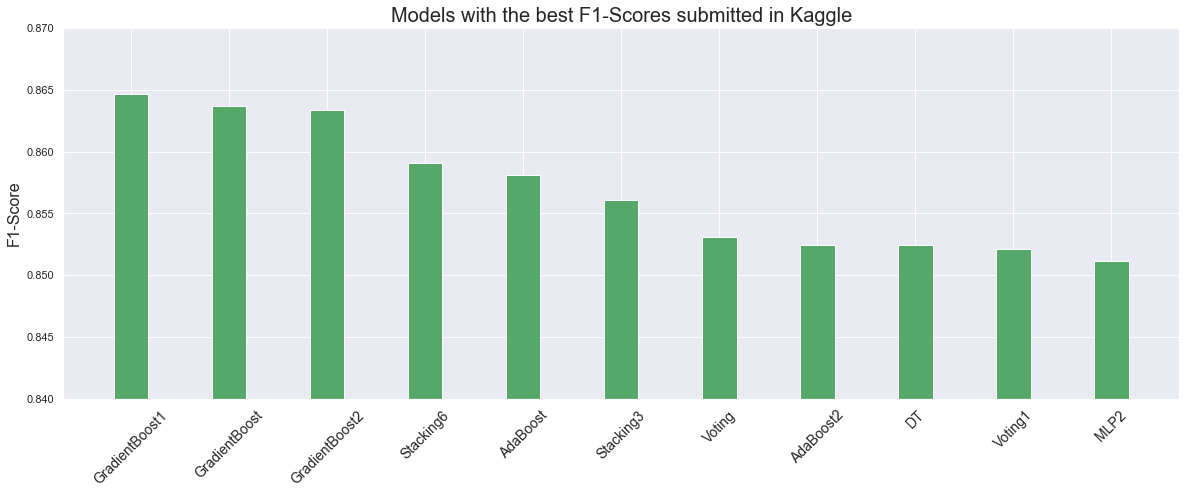

In [258]:
scores_kaggle = [0.86468, 0.86369, 0.86336, 0.85907, 0.85808, 0.85610, 0.85313, 0.85247, 0.85247, 0.85214, 0.85115]

best_models_kaggle = ['GradientBoost1','GradientBoost','GradientBoost2','Stacking6','AdaBoost','Stacking3','Voting','AdaBoost2',
                      'DT','Voting2', 'MLP2']

figure = plt.figure(figsize=(20,15))
ax = figure.add_subplot(212)

ax.bar(np.arange(0,len(best_models_kaggle)), scores_kaggle, width=0.35, color='g', align='center')

ax.set_xticks(np.arange(len(best_models_kaggle)))
ax.set_xticklabels(best_models_kaggle, rotation = 45, fontdict = {'fontsize': 14})

plt.title('Models with the best F1-Scores submitted in Kaggle', fontdict = {'fontsize': 20})
plt.ylabel('F1-Score', fontdict = {'fontsize': 16})
plt.ylim(0.84,0.87)

plt.show()